This notebook is to ccompare FeliX projections with the original SSP projections across output indicators.

In [1]:
import sys
sys.path.append(r'N:\Planet-A\Current-Users\Enayat-Moallemi\EMAworkbench-master')
#sys.path.append(r'C:\Users\moallemie\GitHub\SSPs_SDGs_Assessment')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Load and process SSP data

In [3]:
directory = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Moallemi_et_al_SDG_SSP_Assessment/Data/IIASA_SSP_dataset/' 
df_scenario = pd.read_excel(directory+"SSP_Scenarios.xlsx", sheet_name='IIASA SSPs Data')
df_scenario = df_scenario.drop(['2005','2010'], 1)

df_population = pd.read_excel(directory+"SSP_Population.xlsx", sheet_name='SSPs Data Cumulative')
df_population = df_population.drop(['2010', '2015', '2025', '2035', '2045', '2055', '2065', '2075', '2085', '2095'], 1)

df_gdp = pd.read_excel(directory+"SSP_GDP.xlsx", sheet_name='IIASA SSPs Data')
df_gdp = df_gdp.drop(['2010', '2015', '2025', '2035', '2045', '2055', '2065', '2075', '2085', '2095'], 1)

In [4]:
years = ['2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100']


sc_variables = ['Agricultural Production|Crops|Non-Energy', 
           'Agricultural Production|Livestock', 'Emissions|CO2', 'Energy Demand Indicator', 
           'Land Cover|Cropland', 'Land Cover|Forest', 'Land Cover|Pasture', 
           'Primary Energy|Biomass', 'Primary Energy|Coal', 'Primary Energy|Gas', 'Primary Energy|Oil', 
           'Primary Energy|Solar', 'Primary Energy|Wind', 'Diagnostics|MAGICC6|Forcing|CO2'] 

pop_variables = ['Population', 'Population Primary Education', 'Population Secondary Education', 'Population Tertiary Education']

gdp_variables = df_gdp['VARIABLE'].unique().tolist()

scenarios = ['SSP1-26', 'SSP2-45', 'SSP3-70', 'SSP4-60', 'SSP5-85']


regions = ['World']


sc_models = ['AIM/CGE', 'GCAM4', 'IMAGE', 'MESSAGE-GLOBIOM', 'REMIND-MAGPIE',
       'WITCH-GLOBIOM']

pop_models = df_population['MODEL'].unique().tolist()

gdp_models = df_gdp['MODEL'].unique().tolist()

In [5]:
# This replaces Energy Demand Indicator with Final Energy Demand in industry, transportation, and residential/commercial in the original IIASA Scenario data.

demand_models =  ['AIM/CGE', 'GCAM4', 'IMAGE'] # We choose a subset of models that have estimation for all three sectors.
demand_vars = ['Final Energy|Industry', 'Final Energy|Residential and Commercial', 'Final Energy|Transportation']
df_demand = df_scenario.loc[df_scenario['VARIABLE'].isin(demand_vars)]

# To sum up the demand of the three sectors in each model-scenario estimate sets.
for s, scenario in enumerate(scenarios): 
    for m, model in enumerate(demand_models): 
        df_demand2 = df_demand[(df_demand['SCENARIO'] == scenario) & (df_demand['REGION'] == 'World') 
                              & (df_demand['MODEL'] == model)]
        df_sum = df_demand2.sum(axis=0)
        # To replace the string sumup in columns with string values. 
        df_sum['MODEL', 'SCENARIO', 'REGION', 'VARIABLE', 'UNIT'] = [model, scenario, 'World', 'Energy Demand Indicator', 'EJ/yr']
        df_scenario = df_scenario.append(df_sum, ignore_index=True)

# To remove all rows for sectoral demand from scenario dataframe.
df_scenario = df_scenario.drop(df_scenario[df_scenario['VARIABLE'].isin(demand_vars)].index)
        

In [47]:
dict_var = {}

for v, var in enumerate(sc_variables):
    dict_var[var] = {}
    for s, scenario in enumerate(scenarios):
        df_sc = df_scenario[(df_scenario['SCENARIO'] == scenario) & (df_scenario['REGION'] == 'World') 
                            & (df_scenario['VARIABLE'] == var)]
        df_sc = df_sc.T
        df_sc.reset_index(level=0, inplace=True)
        df_sc.columns = df_sc.iloc[0]
        df_sc2 = df_sc.drop([0,1,2,3,4])
        df_sc3 = df_sc2.rename(columns={"MODEL": "Time"})
        df_sc3['Time'] = df_sc3['Time'].astype(int)
        dict_var[var][scenario] = df_sc3

for v, var in enumerate(pop_variables):
    dict_var[var] = {}
    for s, scenario in enumerate(scenarios):
        df_sc = df_population[(df_population['SCENARIO'] == scenario) & (df_population['REGION'] == 'World') 
                            & (df_population['VARIABLE'] == var)]
        df_sc = df_sc.T
        df_sc.reset_index(level=0, inplace=True)
        df_sc.columns = df_sc.iloc[0]
        df_sc2 = df_sc.drop([0,1,2,3,4])
        df_sc3 = df_sc2.rename(columns={"MODEL": "Time"})
        df_sc3['Time'] = df_sc3['Time'].astype(int)
        dict_var[var][scenario] = df_sc3
    
for v, var in enumerate(gdp_variables):
    dict_var[var] = {}
    for s, scenario in enumerate(scenarios):
        df_sc = df_gdp[(df_gdp['SCENARIO'] == scenario) & (df_gdp['REGION'] == 'World') 
                            & (df_gdp['VARIABLE'] == var)]
        df_sc = df_sc.T
        df_sc.reset_index(level=0, inplace=True)
        df_sc.columns = df_sc.iloc[0]
        df_sc2 = df_sc.drop([0,1,2,3,4])
        df_sc3 = df_sc2.rename(columns={"MODEL": "Time"})
        df_sc3['Time'] = df_sc3['Time'].astype(int)
        dict_var[var][scenario] = df_sc3
        

old_keys = ['Agricultural Production|Crops|Non-Energy', 
                      'Agricultural Production|Livestock', 
                      'Emissions|CO2', 
                      'Land Cover|Cropland', 
                      'Land Cover|Forest', 
                      'Land Cover|Pasture', 
                      'Primary Energy|Biomass', 
                      'Primary Energy|Coal', 
                      'Primary Energy|Gas', 
                      'Primary Energy|Oil', 
                      'Primary Energy|Solar', 
                      'Primary Energy|Wind', 
                      'Diagnostics|MAGICC6|Forcing|CO2',
                      'Population',
                      'Population Primary Education',
                      'Population Secondary Education',
                      'Population Tertiary Education', 
                      'GDP|PPP per capita', 
            'Energy Demand Indicator']
new_keys = ['Nonenergy Crops Production Indicator', 
                      'Livestock Production Indicator', 
                     'Total CO2 Emissions Indicator', 
                      'Total Croplands Indicator', 
                     'Forest Land Indicator', 
                      'Pasture Land Indicator', 
                      'Biomass Energy Production Indicator', 
                      'Coal Production Indicator', 
                      'Gas Production Indicator', 
                      'Oil Production Indicator', 
                      'Solar Energy Production Indicator', 
                      'Wind Energy Production Indicator', 
                      'CO2 Radiative Forcing Indicator',
                      'Total Population Indicator',
                      'Total Primary Education Graduates Indicator',
                     'Total Secondary Education Graduates Indicator',
                      'Total Tertiary Education Graduates Indicator', 
                      'GWP per Capita Indicator', 
            'Energy Demand Indicator']

for new_key, old_key in zip(new_keys, old_keys):
    dict_var[new_key] = dict_var.pop(old_key)
    

# This is to convert population size from million to billion and total emissions from Mt to Gt.
cols = ['IIASA GDP','OECD Env-Growth','PIK GDP-32', 'NCAR', 'IIASA-WiC POP']    
for s, sc in enumerate(scenarios): 
    dict_var['Total Population Indicator'][sc].loc[:,cols] = dict_var['Total Population Indicator'][sc].loc[:, cols].div(1000, axis=0)
    cols2 = list(dict_var['Total CO2 Emissions Indicator'][sc])[1:]
    dict_var['Total CO2 Emissions Indicator'][sc].loc[:,cols2] = dict_var['Total CO2 Emissions Indicator'][sc].loc[:, cols2].div(1000, axis=0)
    

In [48]:
dict_var['Energy Demand Indicator']['SSP1-26']

,Time,AIM/CGE,GCAM4,IMAGE
5,2020,365.995,442.621,356.932
6,2030,371.52,486.78,373.354
7,2040,371.238,529.186,394.813
8,2050,384.763,549.663,404.911
9,2060,380.354,553.423,419.402
10,2070,365.945,548.456,416.806
11,2080,354.505,537.023,403.749
12,2090,340.293,519.601,393.79
13,2100,326.198,498.468,393.93


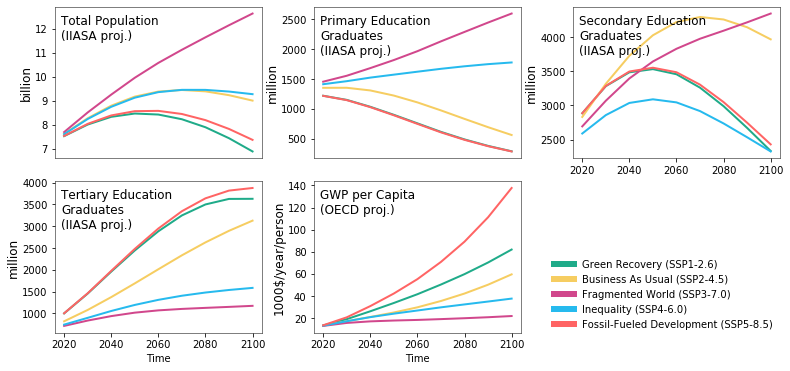

In [49]:
# Develop plots for the refernce values of population, GDP, and education to use in the calibration section of SI.

from textwrap import wrap
from matplotlib.lines import Line2D

  
# Customise y-axis label names to include the units. 
y_labels = {'Total Population Indicator':'billion', 
             'Total Primary Education Graduates Indicator':'million',
             'Total Secondary Education Graduates Indicator':'million',
              'Total Tertiary Education Graduates Indicator':'million', 
              'GWP per Capita Indicator':'1000$/year/person'}

marker_model = {'Total Population Indicator':'IIASA-WiC POP', 
             'Total Primary Education Graduates Indicator':'IIASA-WiC POP',
             'Total Secondary Education Graduates Indicator':'IIASA-WiC POP',
              'Total Tertiary Education Graduates Indicator':'IIASA-WiC POP', 
              'GWP per Capita Indicator':'OECD Env-Growth'}

ssp_names = {'SSP1-26': 'Green Recovery (SSP1-2.6)', 'SSP2-45': 'Business As Usual (SSP2-4.5)', 
             'SSP3-70': 'Fragmented World (SSP3-7.0)', 'SSP4-60': 'Inequality (SSP4-6.0)', 'SSP5-85': 'Fossil-Fueled Development (SSP5-8.5)'}

# Customise plot titles
titles = {'Total Population Indicator':'Total Population\n(IIASA proj.)', 
             'Total Primary Education Graduates Indicator':'Primary Education Graduates     \n(IIASA proj.)',
             'Total Secondary Education Graduates Indicator':'Secondary Education Graduates     \n(IIASA proj.)',
              'Total Tertiary Education Graduates Indicator':'Tertiary Education Graduates     \n(IIASA proj.)', 
              'GWP per Capita Indicator':'GWP per Capita     \n(OECD proj.)'}
 
sc_colors = {'SSP1-26': '#1fab89','SSP2-45':'#f6cd61','SSP3-70':'#d1478c', 'SSP4-60':'#26baee', 'SSP5-85':'#ff6464', 'Historical':'black'}

fig, axes = plt.subplots(2, 3, figsize=(13, 6), sharex='col')
fig.subplots_adjust(hspace=0.15, wspace=0.25)

i = 0
j = 0

for v, var in enumerate(list(y_labels.keys())):

    if j == 3:
        i = 1
        j = 0
    for s, sc in enumerate(scenarios):
        dict_var[var][sc].plot( 'Time', marker_model[var], ax=axes[i,j], marker='',
                                                         color=sc_colors[sc], linewidth=2)
    axes[i,j].legend().set_visible(False)
    axes[i,j].set_ylabel(y_labels[var], size=12, labelpad=2)
    axes[i,j].annotate('\n'.join(wrap(titles[var], 20)), size= 12, xy=(0.03, .95), 
                       xycoords='axes fraction', ha='left', va='top')
    j += 1

axes[1,2].axis('off')

# Removing ticks for inner plots                
for i in range(1):
    for j in range(2):
        axes[i, j].tick_params(bottom=False)
axes[0, 2].tick_params(axis='x', reset=True, top=False)

# Create a single legend for all subplots
legend_elements = [Line2D([0], [0], color=sc_colors[sc], lw=6, alpha=1, label=ssp_names[sc]) for sc in scenarios]

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles=legend_elements, loc='lower right', ncol=1, fontsize=10, 
           bbox_to_anchor=(0.83, 0.087), frameon=False, borderaxespad=0)

plt.savefig('{}/PopGdpEdu_Calibration_600dpi.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), 
            dpi=600,  bbox_inches='tight')
plt.savefig('{}/PopGdpEdu_Calibration_600dpi.pdf'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), 
            dpi=600,  bbox_inches='tight')
plt.savefig('{}/PopGdpEdu_Calibration_300dpi.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), 
            dpi=300,  bbox_inches='tight')


## Load FeliX projections (experiments)

In [8]:
# Import Felix model generated projections under uncertainty to show bands instead of lines. 
from ema_workbench import load_results
directory = 'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Results/Exploration_results/'
dict_sc_felix = {}
dict_sc_felix_g = {}
for i in scenarios:  
    results = load_results(directory+'SDG_{}_exploration_sc10000.tar.gz'.format(i))
    experiments, outcomes = results
    dict_sc_felix[i] = outcomes # for all plotting except changes needed under green growth 
    dict_sc_felix_g[i] = outcomes # for plotting changes needed under the green growth

In [9]:
dict_sc_felix_g['SSP1-26']

{'TIME': array([[1900., 1901., 1902., ..., 2098., 2099., 2100.],
        [1900., 1901., 1902., ..., 2098., 2099., 2100.],
        [1900., 1901., 1902., ..., 2098., 2099., 2100.],
        ...,
        [1900., 1901., 1902., ..., 2098., 2099., 2100.],
        [1900., 1901., 1902., ..., 2098., 2099., 2100.],
        [1900., 1901., 1902., ..., 2098., 2099., 2100.]]),
 'Cereal Yield': array([[ 0.65634   ,  0.68569094,  0.7188353 , ..., 11.188534  ,
         11.24396   , 11.299251  ],
        [ 0.65634   ,  0.68569094,  0.7188353 , ..., 10.450304  ,
         10.496298  , 10.542251  ],
        [ 0.65634   ,  0.68569094,  0.7188353 , ..., 11.716425  ,
         11.776306  , 11.836038  ],
        ...,
        [ 0.65634   ,  0.68569094,  0.7188353 , ..., 11.33598   ,
         11.393381  , 11.450654  ],
        [ 0.65634   ,  0.68569094,  0.7188353 , ..., 10.994808  ,
         11.04513   , 11.095323  ],
        [ 0.65634   ,  0.68569094,  0.7188353 , ..., 11.277934  ,
         11.3351965 , 11.39231

## Plot FeliX vs other IAM projections (main text)

In [50]:
outcomes_dict = {}
for i in scenarios:
    # Delete other output indicators and keep only those used for SSP calibration. We do not plot 'Urban Industrial Land Indicator' for calibration. 
    unwanted = set(list(dict_sc_felix[i].keys())) - set(new_keys+['TIME'])
    for unwanted_key in unwanted: del dict_sc_felix[i][unwanted_key]
        
    # Flatten 2D arrays in outcomes[indicator] to 1D array and create a long-format dataframe for plotting the uncertainty
    # Why we convert outcomes to long-format dataframe? because it's the accepted format of sns.lineplot which draws uncertainty
    outcomes_df = pd.DataFrame(columns=list(dict_sc_felix[i].keys()))
    for key in set(list(dict_sc_felix[i].keys())): 
        outcomes_df[key] = dict_sc_felix[i][key][:, 120:].ravel() # Specify from when to plot the data 
    outcomes_dict[i] = outcomes_df
    
    # To convert population size from million to billion
    outcomes_dict[i]['Total Population Indicator'] = outcomes_dict[i]['Total Population Indicator'].div(1000, axis=0)
    # To convert co2 emissions from Mt to Gt
    outcomes_dict[i]['Total CO2 Emissions Indicator'] = outcomes_dict[i]['Total CO2 Emissions Indicator'].div(1000, axis=0)
    

In [51]:
outcomes_dict['SSP1-26']

,TIME,Pasture Land Indicator,Total Croplands Indicator,Solar Energy Production Indicator,Wind Energy Production Indicator,Biomass Energy Production Indicator,Oil Production Indicator,Gas Production Indicator,Coal Production Indicator,Forest Land Indicator,Total Population Indicator,Total Primary Education Graduates Indicator,Total Secondary Education Graduates Indicator,Total Tertiary Education Graduates Indicator,GWP per Capita Indicator,Energy Demand Indicator,Nonenergy Crops Production Indicator,Livestock Production Indicator,Total CO2 Emissions Indicator,CO2 Radiative Forcing Indicator
0,2020.0,3288.9966,1608.6964,3.662521,1.228411,25.585611,196.976170,169.933070,144.715450,3960.9075,7.571259,940.08960,2787.1636,737.55115,11.962642,591.71540,4221.8940,330.824340,53.100613,2.429566
1,2021.0,3294.7030,1611.4875,4.019471,2.414289,26.053623,197.224330,172.563960,146.898860,3952.1726,7.657923,950.25770,2841.6900,777.86860,12.270564,593.37580,4228.1943,335.020840,53.660480,2.473628
2,2022.0,3299.4148,1613.7921,4.386121,3.546579,26.512436,196.777940,175.059230,149.064130,3944.8806,7.740820,959.91614,2894.9883,819.68220,12.589149,595.36224,4238.1143,338.562230,54.136223,2.517661
3,2023.0,3303.1252,1615.6070,4.758874,4.596621,26.991116,195.393690,177.726580,150.928960,3939.0388,7.820083,969.13430,2947.0938,863.07940,12.919968,597.44006,4249.2417,341.846100,54.469793,2.561528
4,2024.0,3305.9175,1616.9727,5.132863,5.085182,27.497215,191.438570,180.941500,150.496030,3934.5112,7.895841,977.93286,2998.0193,908.10190,13.262184,599.54190,4260.3980,344.619870,54.331970,2.604948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809995,2096.0,2825.3916,1381.9404,123.759450,36.027090,229.807110,24.416914,36.310116,20.512098,4417.7407,6.673625,528.88153,2453.0376,3709.49200,121.014170,494.82535,4094.5305,127.941330,-2.863987,2.572354
809996,2097.0,2819.3372,1378.9791,124.911865,36.805557,226.040730,23.531742,34.676495,19.604881,4426.0474,6.593256,515.40620,2411.4630,3695.12480,124.002975,489.01755,4046.1940,125.732260,-2.966304,2.561713
809997,2098.0,2813.1980,1375.9763,125.955770,37.593400,222.207930,22.677969,33.119465,18.740177,4434.4770,6.512409,502.02438,2369.9540,3679.40000,127.074140,483.17267,3997.3513,123.519970,-3.065952,2.551025
809998,2099.0,2806.9746,1372.9325,126.890460,38.390320,218.318970,21.854588,31.635553,17.915998,4443.0283,6.431141,488.74545,2328.5432,3662.35960,130.230220,477.29483,3948.1333,121.303444,-3.163121,2.540290


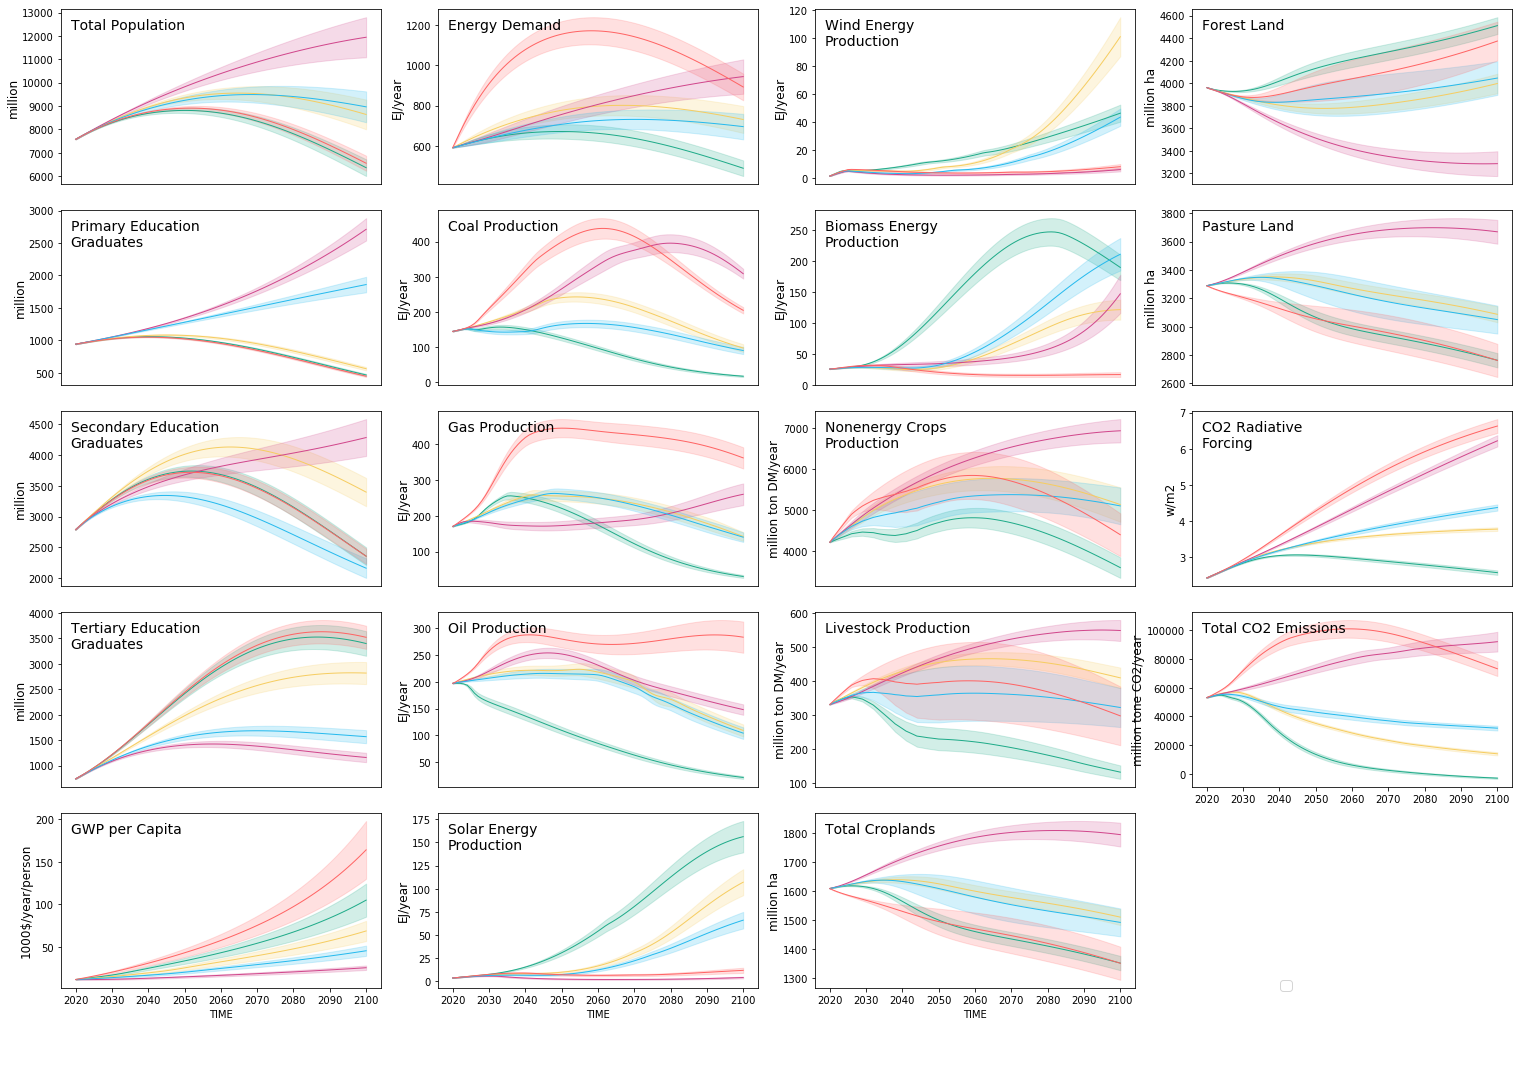

In [13]:
# Ploting Felix SSP projections across outcome variables.

from textwrap import wrap

# Customise y-axis label names to include the units
y_labels = {'Total Population Indicator':'billion', 
             'Total Primary Education Graduates Indicator':'million',
             'Total Secondary Education Graduates Indicator':'million',
              'Total Tertiary Education Graduates Indicator':'million', 
              'GWP per Capita Indicator':'1000$/year/person',
             'Energy Demand Indicator': 'EJ/year',
             'Coal Production Indicator':'EJ/year', 
              'Gas Production Indicator':'EJ/year', 
              'Oil Production Indicator':'EJ/year', 
              'Solar Energy Production Indicator':'EJ/year', 
              'Wind Energy Production Indicator':'EJ/year', 
            'Biomass Energy Production Indicator':'EJ/year',
             'Nonenergy Crops Production Indicator':'million ton DM/year', 
              'Livestock Production Indicator':'million ton DM/year',  
              'Total Croplands Indicator':'million ha', 
             'Forest Land Indicator':'million ha', 
              'Pasture Land Indicator':'million ha', 
              'CO2 Radiative Forcing Indicator': 'w/m2',
             'Total CO2 Emissions Indicator': 'billion tone CO2/year'}

# Customise plot titles
titles = {'Total Population Indicator':'Total Population', 
             'Total Primary Education Graduates Indicator':'Primary Education Graduates',
             'Total Secondary Education Graduates Indicator':'Secondary Education Graduates',
              'Total Tertiary Education Graduates Indicator':'Tertiary Education Graduates', 
              'GWP per Capita Indicator':'GWP per Capita',
             'Energy Demand Indicator': 'Energy Demand',
             'Coal Production Indicator':'Coal Production', 
              'Gas Production Indicator':'Gas Production', 
              'Oil Production Indicator':'Oil Production', 
              'Solar Energy Production Indicator':'Solar Energy Production', 
              'Wind Energy Production Indicator':'Wind Energy Production', 
            'Biomass Energy Production Indicator':'Biomass Energy Production',
             'Nonenergy Crops Production Indicator':'Nonenergy Crops Production', 
              'Livestock Production Indicator':'Livestock Production',  
              'Total Croplands Indicator':'Total Croplands', 
             'Forest Land Indicator':'Forest Land', 
              'Pasture Land Indicator':'Pasture Land', 
              'CO2 Radiative Forcing Indicator': 'CO2 Radiative Forcing',
             'Total CO2 Emissions Indicator': 'Total CO2 Emissions'}

 
    
sc_colors = {'SSP1-26': '#1fab89','SSP2-45':'#f6cd61','SSP3-70':'#d1478c', 'SSP4-60':'#26baee', 'SSP5-85':'#ff6464', 'Historical':'black'}

fig, axes = plt.subplots(5, 4, figsize=(26, 18), sharex='col')
fig.subplots_adjust(hspace=0.15, wspace=0.18)

i = 0
j = 0
for v, var in enumerate(list(y_labels.keys())):
    if i == 5:
        i = 0
        j += 1
    for s, sc in enumerate(scenarios):
        sns.lineplot(x='TIME', y=var, err_style="band", ci='sd', 
                     estimator=np.mean, data=outcomes_dict[sc], ax=axes[i,j], marker='',linewidth=1, color=sc_colors[sc])
    #axes[i,j].legend().set_visible(False)
    axes[i,j].set_ylabel(y_labels[var], size=12, labelpad=2)
    axes[i,j].annotate('\n'.join(wrap(titles[var], 20)), size= 14, xy=(0.03, .95), xycoords='axes fraction', ha='left', va='top')
    i += 1

axes[4,3].axis('off')

# Removing ticks for inner plots                
for i in range(4):
    for j in range(4):
        axes[i, j].tick_params(bottom=False)
axes[3, 3].tick_params(axis='x', reset=True, top=False)

# Create a single legend for all subplots
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=1, fontsize=14, 
           bbox_to_anchor=(0.69, 0.064), fancybox=True, borderaxespad=0)

plt.savefig('{}/SDGs_SSPs_Felix_projection_SI_300dpi.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=300,  bbox_inches='tight') 
plt.savefig('{}/SDGs_SSPs_Felix_projection_SI.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/SDGs_SSPs_Felix_projection_SI.pdf'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/SDGs_SSPs_Felix_projection_SI.svg'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 


In [52]:
# Prapre the datasets for plotting FeliX projections against SSP model projections

from textwrap import wrap
from collections import OrderedDict
from matplotlib.lines import Line2D
import matplotlib as mpl


# Combine FeliX projections across all renewable sources, all fossil sources,  all food production, and all agricultural land
renewable = ['Solar Energy Production Indicator', 'Wind Energy Production Indicator', 'Biomass Energy Production Indicator']
fossil = ['Oil Production Indicator', 'Gas Production Indicator', 'Coal Production Indicator']
food = ['Nonenergy Crops Production Indicator', 'Livestock Production Indicator']
agriland = ['Total Croplands Indicator', 'Pasture Land Indicator']

for s in scenarios:
    outcomes_dict[s]['Renewable Energy Production Indicator'] = outcomes_dict[s][renewable].sum(axis=1)
    outcomes_dict[s]['Fossil Energy Production Indicator'] = outcomes_dict[s][fossil].sum(axis=1)
    outcomes_dict[s]['Food Production Indicator'] = outcomes_dict[s][food].sum(axis=1)
    outcomes_dict[s]['Agricultural Lands Indicator'] = outcomes_dict[s][agriland].sum(axis=1)

    
    
# Combine SSP model projections across all renewable sources, all fossil sources,  all food production, and all agricultural land
new_var = ['Renewable Energy Production Indicator', 'Fossil Energy Production Indicator', 
          'Food Production Indicator', 'Agricultural Lands Indicator']
for v in new_var:
    dict_var[v] = {}
for s in scenarios:
    dict_var[new_var[0]][s] = (dict_var['Solar Energy Production Indicator'][s] 
                                                            + dict_var['Wind Energy Production Indicator'][s] 
                                                            + dict_var['Biomass Energy Production Indicator'][s])
    dict_var[new_var[0]][s]['Time'] = dict_var[new_var[0]][s]['Time']/3
    
    dict_var[new_var[1]][s] = (dict_var['Coal Production Indicator'][s] 
                                                            + dict_var['Gas Production Indicator'][s] 
                                                            + dict_var['Oil Production Indicator'][s])
    dict_var[new_var[1]][s]['Time'] = dict_var[new_var[1]][s]['Time']/3
    dict_var[new_var[2]][s] = (dict_var['Nonenergy Crops Production Indicator'][s] 
                                                            + dict_var['Livestock Production Indicator'][s] )
    dict_var[new_var[2]][s]['Time'] = dict_var[new_var[2]][s]['Time']/2
    dict_var[new_var[3]][s] = (dict_var['Total Croplands Indicator'][s] 
                                                            + dict_var['Pasture Land Indicator'][s])
    dict_var[new_var[3]][s]['Time'] = dict_var[new_var[3]][s]['Time']/2

        

# Create subplots title, colours, and units.
ssp_names = {'SSP1-26': 'Green Recovery\n(SSP1-2.6)', 'SSP2-45': 'Business as usual\n(SSP2-4.5)', 
             'SSP3-70': 'Fragmented world\n(SSP3-7.0)', 'SSP4-60': 'Inequality\n(SSP4-6.0)', 'SSP5-85': 'Fossil-fueled development\n(SSP5-8.5)'}

sc_colors = {'SSP1-26': '#1fab89','SSP2-45':'#f6cd61','SSP3-70':'#d1478c', 'SSP4-60':'#26baee', 'SSP5-85':'#ff6464', 'Historical':'black'}

unit_keys = {'Total Population Indicator':'Total Population\n(billion)', 
             'Total Primary Education Graduates Indicator':'Primary Education Graduates\n(million)',
             'Total Secondary Education Graduates Indicator':'Secondary Education Graduates\n(million)',
              'Total Tertiary Education Graduates Indicator':'Tertiary Education Graduates\n(million)', 
              'GWP per Capita Indicator':'GWP per Capita\n(1000$/year/person)',
             'Energy Demand Indicator': 'Energy Demand\n(EJ/year)',
             'Coal Production Indicator':'Coal Production\n(EJ/year)', 
              'Gas Production Indicator':'Gas Production\n(EJ/year)', 
              'Oil Production Indicator':'Oil Production\n(EJ/year)', 
              'Solar Energy Production Indicator':'Solar Energy Production\n(EJ/year)', 
              'Wind Energy Production Indicator':'Wind Energy Production\n(EJ/year)', 
            'Biomass Energy Production Indicator':'Biomass Energy Production\n(EJ/year)',
             'Nonenergy Crops Production Indicator':'Nonenergy Crops Production\n(million ton DM/year)', 
              'Livestock Production Indicator':'Livestock Production\n(million ton DM/year)',  
              'Total Croplands Indicator':'Total Croplands\n(million ha)', 
             'Forest Land Indicator':'Forest Land\n(million ha)', 
              'Pasture Land Indicator':'Pasture Land\n(million ha)', 
              'CO2 Radiative Forcing Indicator': 'CO2 Radiative Forcing\n(w/m2)',
             'Total CO2 Emissions Indicator': 'Total CO2 Emissions\n(Gt CO2/year)', 
             'Renewable Energy Production Indicator':'Renewable Energy Production\n(EJ/year)', 
             'Fossil Energy Production Indicator':'Fossil Energy Production\n(EJ/year)', 
             'Food Production Indicator':'Food Production\n(million ton DM/year)', 
             'Agricultural Lands Indicator':'Agricultural Lands\n(million ha)'}

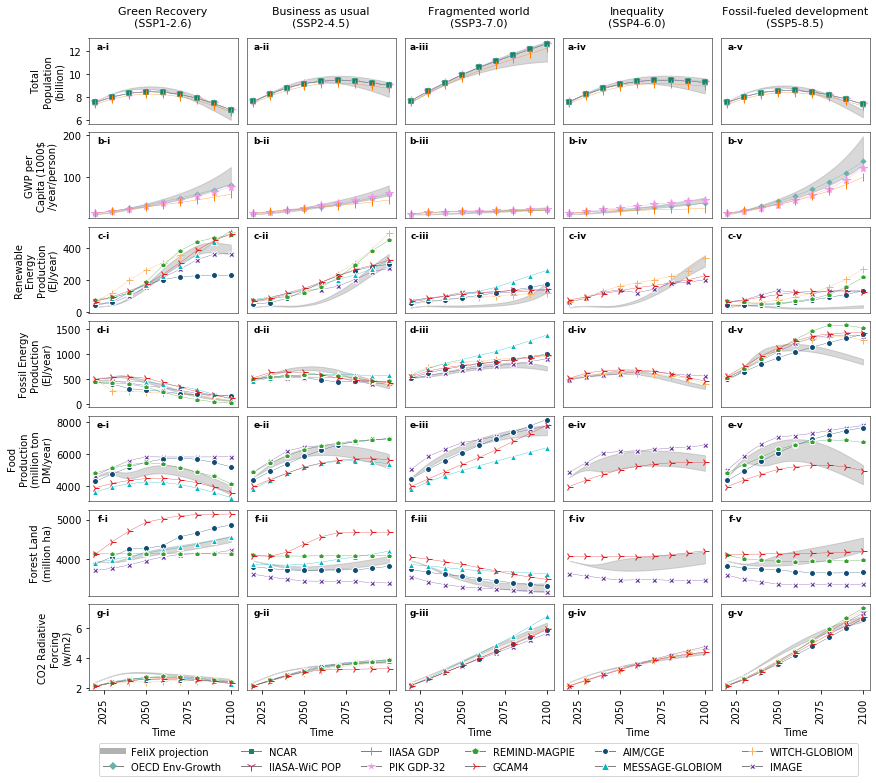

In [53]:
# Develop the  summary calibration plots for the main text

import string

row = 7
fig, ax = plt.subplots(row, 5, figsize=(14, 12), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.1, wspace=0.06)

calib_vars = ['Total Population Indicator', 'GWP per Capita Indicator',
              'Renewable Energy Production Indicator', 'Fossil Energy Production Indicator', 'Food Production Indicator', 
               'Forest Land Indicator', 'CO2 Radiative Forcing Indicator']

for s, sc in enumerate(scenarios):
    
    # Marker dictionary: the first is marker stye, the second is marker size, the third is marker edge size, the fourth is marker edge colour
    markers = {'OECD Env-Growth':["D", 4, .3, '#68b0ab', '#68b0ab'],
     'NCAR':["s", 6, .4, 'white', '#158467'],
     'IIASA-WiC POP':["1", 10, .4, '#e11d74', '#e11d74'],
     'REMIND-MAGPIE':["p", 6, 1, 'white', '#33a02c'],
     'GCAM4':["4", 8, 1, '#e31a1c', '#e31a1c'],
     'WITCH-GLOBIOM':["+", 7, 1, '#fdb462', '#fdb462'],
     'IIASA GDP':["|", 8, 1, '#ff7f00', '#ff7f00'],
     'IMAGE':["X", 6, 1, 'white', '#6a3d9a'],
     'AIM/CGE':["o", 6, 1, 'white', '#0f4c75'],
     'PIK GDP-32':["*", 8, 1, '#f09ae9', '#f09ae9'],
     'MESSAGE-GLOBIOM':["^", 6, 1, 'white', '#00b7c2']}
    
    for v, var in enumerate(calib_vars):
        
        # Renaming is for replacing var name with the model name (FeliX) for having fig legends with model name
        dict_sc_felix2 = outcomes_dict[sc].rename(columns={var:'FeliX'})
        sns.lineplot(x='TIME', y='FeliX', err_style="band", ci='sd', 
                     estimator=np.mean, data=dict_sc_felix2, ax=ax[v,s], marker='', linewidth=0, 
                     color='grey', err_kws={'alpha':.3})
        #ax[v,s].legend().set_visible(False)
        
        ax[v,0].set_ylabel('\n'.join(wrap(unit_keys[var], 13)))
        
        for model in list(set(sc_models+pop_models+gdp_models)):
            if model in dict_var[var][sc].columns:
                dict_var[var][sc].plot( 'Time', model, ax=ax[v,s], marker=markers[model][0], 
                                                             markersize=markers[model][1], markeredgewidth=markers[model][2],
                                                             markerfacecolor=markers[model][4], markeredgecolor=markers[model][3], 
                                                             color=markers[model][4], linewidth=.3)
                ax[v,s].legend().set_visible(False)

        
        # Add all subplot labels
        fig_label = list(string.ascii_lowercase)
        fig_sc = ['-i', '-ii', '-iii', '-iv', '-v']
        ax[v,s].text(.1, .9, fig_label[v]+fig_sc[s], fontsize=9, fontweight='semibold', rotation=0,
                            horizontalalignment='center', verticalalignment='center', transform=ax[v,s].transAxes)
        
    
    # Set plots title only for the first row
    ax[0,s].set_title(ssp_names[sc], fontsize=11, color='black', pad=12) 
                
# Removing ticks for inner plots                
for i in range(row):
    for j in range(5):
        if i in range(row-1) and j in range(5):
            ax[i, j].tick_params(bottom=False)
        if i in range(row) and j in [1,2,3,4]:
            ax[i, j].tick_params(left=False)
        if i in [row-1] and j in range(5):
            ax[i, j].tick_params(axis='x', rotation=90)    
            
            
# Change the color of legends and have a single unified color legend box for all subplots across SSPs 
legend_elements = [Line2D([0], [0], color='black', lw=6, alpha=.3, label='FeliX projection'),
                   Line2D([0], [0], marker="D", color='grey', lw=1, label='OECD Env-Growth', markersize=5, markerfacecolor=markers['OECD Env-Growth'][4], markeredgewidth=0, markeredgecolor='white'),
                   Line2D([0], [0], marker="s", color='grey', lw=1, label='NCAR', markersize=5, markerfacecolor=markers['NCAR'][4], markeredgewidth=0, markeredgecolor='white'),
                   Line2D([0], [0], marker="1", color='grey', lw=1, label='IIASA-WiC POP', markersize=10, markerfacecolor=markers['IIASA-WiC POP'][4], markeredgewidth=1, markeredgecolor=markers['IIASA-WiC POP'][4]),
                   Line2D([0], [0], marker="|", color='grey', lw=1,label='IIASA GDP', markersize=8, markerfacecolor=markers['IIASA GDP'][4], markeredgewidth=1, markeredgecolor=markers['IIASA GDP'][4]),
                   Line2D([0], [0], marker="*", color='grey', lw=1,label='PIK GDP-32', markersize=12, markerfacecolor=markers['PIK GDP-32'][4], markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="p", color='grey', lw=1,label='REMIND-MAGPIE', markersize=8, markerfacecolor=markers['REMIND-MAGPIE'][4], markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="4", color='grey', lw=1,label='GCAM4', markersize=8, markerfacecolor=markers['GCAM4'][4], markeredgewidth=1, markeredgecolor=markers['GCAM4'][4]),
                   Line2D([0], [0], marker="o", color='grey', lw=1,label='AIM/CGE', markersize=6, markerfacecolor=markers['AIM/CGE'][4], markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="^", color='grey', lw=1,label='MESSAGE-GLOBIOM', markersize=8, markerfacecolor=markers['MESSAGE-GLOBIOM'][4], markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="+", color='grey', lw=1,label='WITCH-GLOBIOM', markersize=8, markerfacecolor=markers['WITCH-GLOBIOM'][4], markeredgewidth=1, markeredgecolor=markers['WITCH-GLOBIOM'][4]),
                   Line2D([0], [0], marker="X", color='grey', lw=1,label='IMAGE', markersize=6, markerfacecolor=markers['IMAGE'][4], markeredgewidth=1, markeredgecolor='white')
                  ]


fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.13, .07),  bbox_transform=fig.transFigure, ncol=6)

mpl.rcParams['axes.linewidth'] =.5

plt.savefig('{}/SSPs_calibration_plots_maintext_300dpi.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=300,  bbox_inches='tight') 
plt.savefig('{}/SSPs_calibration_plots_maintext.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/SSPs_calibration_plots_maintext.pdf'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/SSPs_calibration_plots_maintext.svg'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 

plt.show()

## Plotting FeliX vs other IAM projections (SI)

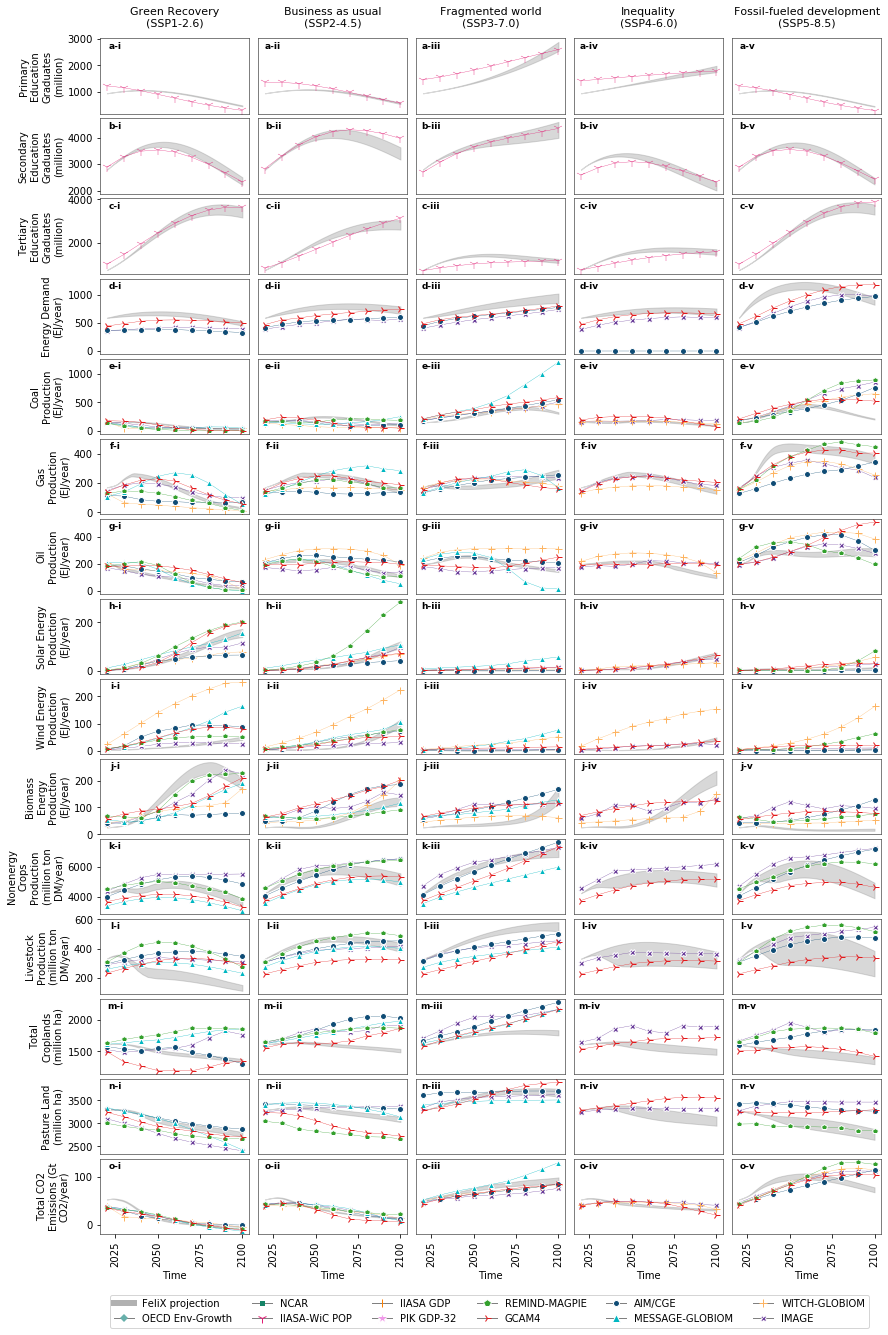

In [54]:
# Develop the  deatiled calibration plots for the SI

row = 15
fig, ax = plt.subplots(row, 5, figsize=(14, 22), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.06, wspace=0.06)



calib_vars = ['Total Primary Education Graduates Indicator',
            'Total Secondary Education Graduates Indicator',
            'Total Tertiary Education Graduates Indicator', 
            'Energy Demand Indicator',
            'Coal Production Indicator' ,
            'Gas Production Indicator',
            'Oil Production Indicator',
            'Solar Energy Production Indicator',
            'Wind Energy Production Indicator',
            'Biomass Energy Production Indicator',
            'Nonenergy Crops Production Indicator' ,
            'Livestock Production Indicator',
            'Total Croplands Indicator',
            'Pasture Land Indicator',
            'Total CO2 Emissions Indicator']

for s, sc in enumerate(scenarios):
    
    # Marker dictionary: the first is marker stye, the second is marker size, the third is marker edge size, the fourth is marker edge colour
    markers = {'OECD Env-Growth':["D", 4, .3, '#68b0ab', '#68b0ab'],
     'NCAR':["s", 6, .4, 'white', '#158467'],
     'IIASA-WiC POP':["1", 10, .4, '#e11d74', '#e11d74'],
     'REMIND-MAGPIE':["p", 6, 1, 'white', '#33a02c'],
     'GCAM4':["4", 8, 1, '#e31a1c', '#e31a1c'],
     'WITCH-GLOBIOM':["+", 7, 1, '#fdb462', '#fdb462'],
     'IIASA GDP':["|", 8, 1, '#ff7f00', '#ff7f00'],
     'IMAGE':["X", 6, 1, 'white', '#6a3d9a'],
     'AIM/CGE':["o", 6, 1, 'white', '#0f4c75'],
     'PIK GDP-32':["*", 8, 1, '#f09ae9', '#f09ae9'],
     'MESSAGE-GLOBIOM':["^", 6, 1, 'white', '#00b7c2']}
    
    for v, var in enumerate(calib_vars):
        
        # Renaming is for replacing var name with the model name (FeliX) for having fig legends with model name
        dict_sc_felix2 = outcomes_dict[sc].rename(columns={var:'FeliX'})
        sns.lineplot(x='TIME', y='FeliX', err_style="band", ci='sd', 
                     estimator=np.mean, data=dict_sc_felix2, ax=ax[v,s], marker='', linewidth=0, 
                     color='grey', err_kws={'alpha':.3})
        #ax[v,s].legend().set_visible(False)
        
        ax[v,0].set_ylabel('\n'.join(wrap(unit_keys[var], 13)))
        
        for model in list(set(sc_models+pop_models+gdp_models)):
            if model in dict_var[var][sc].columns:
                dict_var[var][sc].plot( 'Time', model, ax=ax[v,s], marker=markers[model][0], 
                                                             markersize=markers[model][1], markeredgewidth=markers[model][2],
                                                             markerfacecolor=markers[model][4], markeredgecolor=markers[model][3], 
                                                             color=markers[model][4], linewidth=.3)
                ax[v,s].legend().set_visible(False)

        # Add all subplot labels
        fig_label = list(string.ascii_lowercase)
        fig_sc = ['-i', '-ii', '-iii', '-iv', '-v']
        ax[v,s].text(.1, .9, fig_label[v]+fig_sc[s], fontsize=9, fontweight='semibold', rotation=0,
                            horizontalalignment='center', verticalalignment='center', transform=ax[v,s].transAxes)
    
    
    # Set plots title only for the first row
    ax[0,s].set_title(ssp_names[sc], fontsize=11, color='black', pad=12) 
                
# Removing ticks for inner plots                
for i in range(row):
    for j in range(5):
        if i in range(row-1) and j in range(5):
            ax[i, j].tick_params(bottom=False)
        if i in range(row) and j in [1,2,3,4]:
            ax[i, j].tick_params(left=False)
        if i in [row-1] and j in range(5):
            ax[i, j].tick_params(axis='x', rotation=90)    
            
            
# Change the color of legends and have a single unified color legend box for all subplots across SSPs 
legend_elements = [Line2D([0], [0], color='black', lw=6, alpha=.3, label='FeliX projection'),
                   Line2D([0], [0], marker="D", color='grey', lw=1, label='OECD Env-Growth', markersize=5, markerfacecolor=markers['OECD Env-Growth'][4], markeredgewidth=0, markeredgecolor='white'),
                   Line2D([0], [0], marker="s", color='grey', lw=1, label='NCAR', markersize=5, markerfacecolor=markers['NCAR'][4], markeredgewidth=0, markeredgecolor='white'),
                   Line2D([0], [0], marker="1", color='grey', lw=1, label='IIASA-WiC POP', markersize=10, markerfacecolor=markers['IIASA-WiC POP'][4], markeredgewidth=1, markeredgecolor=markers['IIASA-WiC POP'][4]),
                   Line2D([0], [0], marker="|", color='grey', lw=1,label='IIASA GDP', markersize=8, markerfacecolor=markers['IIASA GDP'][4], markeredgewidth=1, markeredgecolor=markers['IIASA GDP'][4]),
                   Line2D([0], [0], marker="*", color='grey', lw=1,label='PIK GDP-32', markersize=12, markerfacecolor=markers['PIK GDP-32'][4], markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="p", color='grey', lw=1,label='REMIND-MAGPIE', markersize=8, markerfacecolor=markers['REMIND-MAGPIE'][4], markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="4", color='grey', lw=1,label='GCAM4', markersize=8, markerfacecolor=markers['GCAM4'][4], markeredgewidth=1, markeredgecolor=markers['GCAM4'][4]),
                   Line2D([0], [0], marker="o", color='grey', lw=1,label='AIM/CGE', markersize=6, markerfacecolor=markers['AIM/CGE'][4], markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="^", color='grey', lw=1,label='MESSAGE-GLOBIOM', markersize=8, markerfacecolor=markers['MESSAGE-GLOBIOM'][4], markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="+", color='grey', lw=1,label='WITCH-GLOBIOM', markersize=8, markerfacecolor=markers['WITCH-GLOBIOM'][4], markeredgewidth=1, markeredgecolor=markers['WITCH-GLOBIOM'][4]),
                   Line2D([0], [0], marker="X", color='grey', lw=1,label='IMAGE', markersize=6, markerfacecolor=markers['IMAGE'][4], markeredgewidth=1, markeredgecolor='white')
                  ]


fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.13, .09),  bbox_transform=fig.transFigure, ncol=6)

mpl.rcParams['axes.linewidth'] =.5

plt.savefig('{}/SSPs_calibration_plots_SI_300dpi.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=300,  bbox_inches='tight') 
plt.savefig('{}/SSPs_calibration_plots_SI.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/SSPs_calibration_plots_SI.pdf'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/SSPs_calibration_plots_SI.svg'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 

plt.show()

## Plot changes needed under a green growth (main text)

In [86]:
# Import Felix model generated projections under uncertainty to show bands instead of lines. 
from ema_workbench import load_results
directory = 'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Results/Exploration_results/'
dict_sc_felix = {}
dict_sc_felix_g = {}
for i in scenarios:  
    results = load_results(directory+'SDG_{}_exploration_sc10000.tar.gz'.format(i))
    experiments, outcomes = results
    dict_sc_felix_g[i] = outcomes # for plotting changes needed under the green growth

In [87]:
wanted_keys = set(['Total Population Indicator', 'GWP per Capita Indicator',
                   'Population with No or Incomplete Education Indicator', 'Energy Demand Indicator', 
                   'Fossil Energy Production Indicator', 'Agricultural Land Area', 
                   'Animal Food Caloric Intake Indicator', 'Atmospheric Concentration CO2', 
                   'TIME'])
dict_sc_felix3 = {}
outcomes_dict2 = {}
for i in ['SSP1-26', 'SSP2-45']: #, 'SSP2', 'SSP3', 'SSP4','SSP5'
    # Delete other output indicators and keep only those used for SSP calibration. We do not plot 'Urban Industrial Land Indicator' for calibration. 
    dict_sc_felix3[i] = dict_sc_felix_g[i]
    unwanted = set(list(dict_sc_felix3[i].keys())) - wanted_keys
    for unwanted_key in unwanted: del dict_sc_felix3[i][unwanted_key]
        
    # Flatten 2D arrays in outcomes[indicator] to 1D array and create a long-format dataframe for plotting the uncertainty
    # Why we convert outcomes to long-format dataframe? because it's the accepted format of sns.lineplot which draws uncertainty
    outcomes_df2 = pd.DataFrame(columns=list(dict_sc_felix3[i].keys()))
    for key in set(list(dict_sc_felix3[i].keys())): 
        outcomes_df2[key] = dict_sc_felix3[i][key][:, 115:].ravel() # Specify from when to plot the data 
    outcomes_dict2[i] = outcomes_df2
    
    # Correct the units for visualtion. Total Population from million to billion; GWP from 1000 to 10000; Livestock Production from million t DM to billion t DM;Agricultural Land from million ha to billion ha 
    outcomes_dict2[i]['Total Population Indicator'] = outcomes_dict2[i]['Total Population Indicator']/1000
    outcomes_dict2[i]['GWP per Capita Indicator'] = outcomes_dict2[i]['GWP per Capita Indicator']/10
    #outcomes_dict2[i]['Livestock Production Indicator'] = outcomes_dict2[i]['Livestock Production Indicator']/1000
    outcomes_dict2[i]['Agricultural Land Area'] = outcomes_dict2[i]['Agricultural Land Area']/1000
    #outcomes_dict2[i]['Total CO2 Emissions Indicator'] = outcomes_dict2[i]['Total CO2 Emissions Indicator']/1000


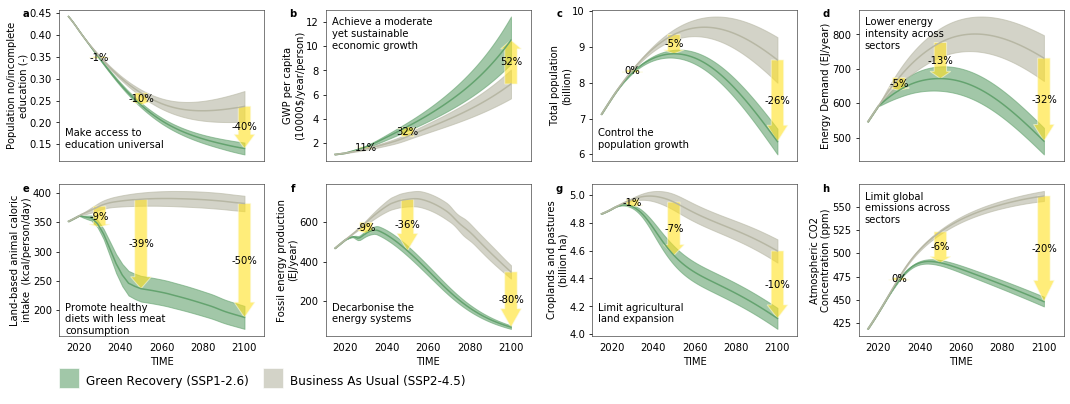

In [94]:
# Ploting Felix SSP projections across outcome variables.
from textwrap import wrap
import matplotlib.patches as patches
import string
from matplotlib.lines import Line2D


# Customise y-axis label names to include the units
y_labels = {'Population with No or Incomplete Education Indicator':'Population no/incomplete education (-)',
            'GWP per Capita Indicator': 'GWP per capita (10000$/year/person)',
            'Total Population Indicator':'Total population (billion)', 
            'Energy Demand Indicator': 'Energy Demand (EJ/year)', 
            'Animal Food Caloric Intake Indicator': 'Land-based animal caloric intake  (kcal/person/day)',
            'Fossil Energy Production Indicator':'Fossil energy production (EJ/year)',  
            'Agricultural Land Area':'Croplands and pastures (billion ha)', 
            'Atmospheric Concentration CO2': 'Atmospheric CO2 Concentration (ppm)'            
             }

# Customise plot titles
titles = {'Population with No or Incomplete Education Indicator':'Make access to education universal',
          'GWP per Capita Indicator':'Achieve a moderate yet sustainable economic growth',
          'Total Population Indicator':'Control the population growth', 
             'Energy Demand Indicator': 'Lower energy intensity across sectors',
          'Animal Food Caloric Intake Indicator': 'Promote healthy diets with less meat consumption', 
             'Fossil Energy Production Indicator':'Decarbonise the energy systems',
             'Agricultural Land Area' : 'Limit agricultural land expansion', 
             'Atmospheric Concentration CO2': 'Limit global emissions across sectors'}


    
sc_colors = {'SSP1-26': '#64a36f','SSP2-45':'#b7b7a4'} #

fig, axes = plt.subplots(2, 4, figsize=(18, 6), sharex='col')
fig.subplots_adjust(hspace=0.15, wspace=0.3)

# Create plot labels
fig_label = list(string.ascii_lowercase) 

i = 0
j = 0
for v, var in enumerate(list(y_labels.keys())):
    if j == 4:
        j = 0
        i += 1
    for s, sc in enumerate(['SSP1-26', 'SSP2-45']):
        sns.lineplot(x='TIME', y=var, err_style="band", ci='sd', 
                     estimator=np.mean, data=outcomes_dict2[sc], ax=axes[i,j], marker='',linewidth=1.5, 
                     color=sc_colors[sc], alpha=1, err_kws={'alpha':.6})
        
                
        # Draw vertical lines at target years
        if sc in ['SSP1-26']:
            for year in [2030, 2050, 2100]:
                ssp1_val = np.mean(outcomes_dict2['SSP1-26'].loc[outcomes_dict2['SSP1-26']['TIME']==year][var])
                ssp2_val = np.mean(outcomes_dict2['SSP2-45'].loc[outcomes_dict2['SSP2-45']['TIME']==year][var])
                
                # draw a simple line between SSP1 and SSP2
                #x = [year]
                #y = [(ssp1_val, ssp2_val)]
                #axes[i,j].plot((x,x),([m for (m,n) in y], [n for (m,n) in y]),c='black', lw=1, ls='--')
                perc_val = int(((ssp1_val-ssp2_val)/ssp2_val)*100)
                axes[i,j].annotate(str(perc_val)+'%', (year,(abs(ssp2_val-ssp1_val)/2+min(ssp2_val,ssp1_val))), 
                                   ha='center', va='center')

                # draw an arrow patch between SSP1 and SSP2 with the arrow headsize proportional to the y axis 
                if (var=='Population with No or Incomplete Education Indicator'):
                    headlen = 3
                if (var=='Fossil Energy Production Indicator'):
                    headlen = 3
                if (var=='Animal Food Caloric Intake Indicator'):
                    headlen = 7.5
                if (var=='Atmospheric Concentration CO2'):
                    headlen = 5
                if (var in ['Total Population Indicator', 'GWP per Capita Indicator', 'Energy Demand Indicator', 'Agricultural Land Area']):
                    headlen = 5
                axes[i,j].add_patch(patches.FancyArrow(year, ssp2_val, 0, ssp1_val-ssp2_val, length_includes_head=True, 
                                                       width=6, head_width= 10, 
                                                       head_length=abs(ssp1_val-ssp2_val)/headlen, 
                                                       alpha=0.6,facecolor='#ffe121', edgecolor='#fbfae1'))
                
                '''# Mark the predictions from other IAMs
                if var in list(unit_keys.keys()):
                    for model in list(set(sc_models+pop_models+gdp_models)):
                        if model in dict_var[var]['SSP1-Baseline'].columns:
                            x_marker = year
                            model_val = dict_var[var]['SSP1-Baseline']
                            y_marker = model_val.loc[model_val['Time']==year][model]               

                            axes[i,j].plot(x_marker, y_marker, linestyle="None", marker='^', alpha=0.5, markersize=10,  
                                                   markeredgecolor='#ffdd00',color='#f75f00')'''
    
    # To correct the formarting of the y-axis to appear with scietific format
    #axes[i,j].ticklabel_format(style='sci',axis='y',scilimits=(-1,2))
    
    axes[i,j].set_ylabel('\n'.join(wrap(y_labels[var], 25)) , size=10, labelpad=1)
    
    if var in ['Agricultural Land Area', 'Total Population Indicator', 'Population with No or Incomplete Education Indicator', 'Fossil Energy Production Indicator', 'Animal Food Caloric Intake Indicator']:
        axes[i,j].annotate('\n'.join(wrap(titles[var], 20)), size= 10, xy=(0.03, .22), xycoords='axes fraction', ha='left', va='top')
    else:
        axes[i,j].annotate('\n'.join(wrap(titles[var], 20)), size= 10, xy=(0.03, .95), xycoords='axes fraction', ha='left', va='top')
    
    # Add all subplot labels  
    axes[i,j].text(-.16, .97, fig_label[v], fontsize=10, fontweight='semibold', rotation=0,
                        horizontalalignment='center', verticalalignment='center', transform=axes[i,j].transAxes)
    
    j += 1

# Removing ticks for inner plots                
for i in range(2):
    for j in range(4):
        axes[i, j].tick_params(bottom=False)

# Create legend for the SSPs
legend_elements = []

ssp_names = {'SSP1-26': 'Green Recovery (SSP1-2.6)', 'SSP2-45': 'Business As Usual (SSP2-4.5)'}
for i in ['SSP1-26', 'SSP2-45']:
    legend_elements.append(Line2D([0], [0], marker="s", color='none', label=ssp_names[i], 
                                  markersize=20, markeredgecolor='white', markerfacecolor=sc_colors[i], alpha=.6))

fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.12, .02, .4, .05), frameon=False, 
           bbox_transform=fig.transFigure, ncol=20, 
           handlelength=1, columnspacing=1.5, handletextpad=.9, labelspacing=.01, fontsize=12, handleheight=2.4)

plt.savefig('{}/SDGs_SSPs_Felix_GreenChange_maintext_300dpi.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=300,  bbox_inches='tight') 
plt.savefig('{}/SDGs_SSPs_Felix_GreenChange_maintext.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/SDGs_SSPs_Felix_GreenChange_maintext.pdf'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/SDGs_SSPs_Felix_GreenChange_maintext.svg'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 


In [91]:
columns = list(y_labels.keys())
index = [2030, 2050, 2100]
change_range_pd = pd.DataFrame(index=index, columns=columns)
for v, var in enumerate(list(y_labels.keys())):
    for year in [2030, 2050, 2100]:
        ssp1_mean = np.mean(outcomes_dict2['SSP1-26'].loc[outcomes_dict2['SSP1-26']['TIME']==year][var])
        ssp1_std = np.std(outcomes_dict2['SSP1-26'].loc[outcomes_dict2['SSP1-26']['TIME']==year][var])
        ssp2_mean = np.mean(outcomes_dict2['SSP2-45'].loc[outcomes_dict2['SSP2-45']['TIME']==year][var])
        range_mean = int(((ssp1_mean-ssp2_mean)/ssp2_mean)*100)
        ssp2_std = np.std(outcomes_dict2['SSP2-45'].loc[outcomes_dict2['SSP2-45']['TIME']==year][var])
        
        if ssp1_mean > ssp2_mean:
            range_min = int((((ssp1_mean-ssp1_std)-(ssp2_mean+ssp2_std))/(ssp2_mean+ssp2_std))*100)
            if range_min < 0:
                range_min = 0
            range_max = int((((ssp1_mean+ssp1_std)-(ssp2_mean-ssp2_std))/(ssp2_mean-ssp2_std))*100)
        else:
            range_max = int((((ssp1_mean-ssp1_std)-(ssp2_mean+ssp2_std))/(ssp2_mean+ssp2_std))*100)
            range_min = int((((ssp1_mean+ssp1_std)-(ssp2_mean-ssp2_std))/(ssp2_mean-ssp2_std))*100)
        
        change_range_pd.loc[year, var] = [range_min, range_mean, range_max]
        
change_range_pd

,Total Population Indicator,GWP per Capita Indicator,Population with No or Incomplete Education Indicator,Energy Demand Indicator,Fossil Energy Production Indicator,Agricultural Land Area,Animal Food Caloric Intake Indicator,Atmospheric Concentration CO2
2030,"[0, 0, -1]","[0, 11, 24]","[0, -1, -2]","[0, -5, -11]","[-5, -9, -13]","[0, -1, -1]","[-5, -9, -12]","[0, 0, 0]"
2050,"[-3, -5, -8]","[7, 32, 61]","[-5, -10, -14]","[-3, -13, -22]","[-29, -36, -42]","[-5, -7, -10]","[-31, -39, -46]","[-5, -6, -7]"
2100,"[-16, -26, -35]","[5, 52, 118]","[-23, -40, -53]","[-20, -32, -43]","[-75, -80, -84]","[-7, -10, -13]","[-43, -50, -57]","[-18, -20, -21]"


## Archive

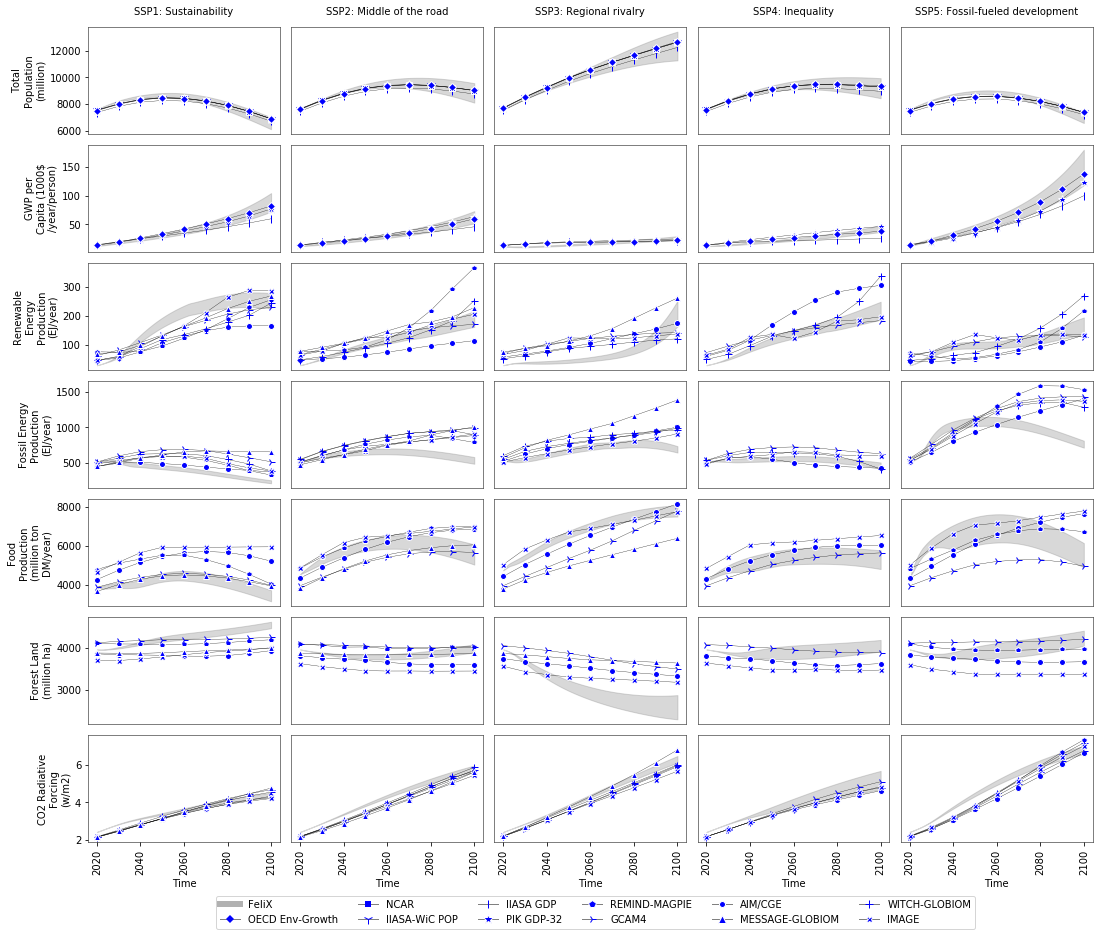

In [343]:
# Develop the  summary plots for the main text

row = 7
fig, ax = plt.subplots(row, 5, figsize=(18, 15), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.1, wspace=0.06)

calib_vars = ['Total Population Indicator', 'GWP per Capita Indicator',
              'Renewable Energy Production Indicator', 'Fossil Energy Production Indicator', 'Food Production Indicator', 
               'Forest Land Indicator', 'CO2 Radiative Forcing Indicator']


for s, sc in enumerate(['SSP1', 'SSP2', 'SSP3', 'SSP4','SSP5']):
    
    # Marker dictionary: the first is marker stye, the second is marker size, the third is marker edge size, the fourth is marker edge colour
    markers = {'OECD Env-Growth':["D", 6, 1, 'white'],
     'NCAR':["s", 6, 1, 'white'],
     'IIASA-WiC POP':["1", 10, 1, 'blue'],
     'REMIND-MAGPIE':["p", 6, 1, 'white'],
     'GCAM4':["4", 8, 1, 'blue'],
     'WITCH-GLOBIOM':["+", 7, 1, 'blue'],
     'IIASA GDP':["|", 8, 1, 'blue'],
     'IMAGE':["X", 6, 1, 'white'],
     'AIM/CGE':["o", 6, 1, 'white'],
     'PIK GDP-32':["*", 9, 1, 'white'],
     'MESSAGE-GLOBIOM':["^", 6, 1, 'white']}
    
    for v, var in enumerate(calib_vars):
        
        # Renaming is for replacing var name with the model name (FeliX) for having fig legends with model name
        dict_sc_felix2 = outcomes_dict[sc].rename(columns={var:'FeliX'})
        sns.lineplot(x='TIME', y='FeliX', err_style="band", ci='sd', 
                     estimator=np.mean, data=dict_sc_felix2, ax=ax[v,s], marker='', linewidth=0, 
                     color='grey', err_kws={'alpha':.3})
        #ax[v,s].legend().set_visible(False)
        
        ax[v,0].set_ylabel('\n'.join(wrap(unit_keys[var], 13)))
        
        for model in list(set(sc_models+pop_models+gdp_models)):
            if model in dict_var[var]['{}-Baseline'.format(sc)].columns:
                dict_var[var]['{}-Baseline'.format(sc)].plot( 'Time', model, ax=ax[v,s], marker=markers[model][0], 
                                                             markersize=markers[model][1], markeredgewidth=markers[model][2],
                                                             markerfacecolor='blue', markeredgecolor=markers[model][3], 
                                                             color='black', linewidth=.3)
                ax[v,s].legend().set_visible(False)

    # Set plots title only for the first row
    ax[0,s].set_title(ssp_names[sc], fontsize=10, color='black', pad=12) 
                
# Removing ticks for inner plots                
for i in range(row):
    for j in range(5):
        if i in range(row-1) and j in range(5):
            ax[i, j].tick_params(bottom=False)
        if i in range(row) and j in [1,2,3,4]:
            ax[i, j].tick_params(left=False)
        if i in [row-1] and j in range(5):
            ax[i, j].tick_params(axis='x', rotation=90)    
            
            
# Change the color of legends and have a single unified color legend box for all subplots across SSPs 
legend_elements = [Line2D([0], [0], color='black', lw=6, alpha=.3, label='FeliX'),
                   Line2D([0], [0], marker="D", color='grey', lw=1, label='OECD Env-Growth', markersize=6, markerfacecolor='blue', markeredgewidth=0, markeredgecolor='white'),
                   Line2D([0], [0], marker="s", color='grey', lw=1, label='NCAR', markersize=6, markerfacecolor='blue', markeredgewidth=0, markeredgecolor='white'),
                   Line2D([0], [0], marker="1", color='grey', lw=1, label='IIASA-WiC POP', markersize=10, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='blue'),
                   Line2D([0], [0], marker="|", color='grey', lw=1,label='IIASA GDP', markersize=8, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='blue'),
                   Line2D([0], [0], marker="*", color='grey', lw=1,label='PIK GDP-32', markersize=10, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="p", color='grey', lw=1,label='REMIND-MAGPIE', markersize=8, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="4", color='grey', lw=1,label='GCAM4', markersize=8, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='blue'),
                   Line2D([0], [0], marker="o", color='grey', lw=1,label='AIM/CGE', markersize=6, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="^", color='grey', lw=1,label='MESSAGE-GLOBIOM', markersize=8, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="+", color='grey', lw=1,label='WITCH-GLOBIOM', markersize=8, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='blue'),
                   Line2D([0], [0], marker="X", color='grey', lw=1,label='IMAGE', markersize=6, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='white')
                  ]

fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.22, .08),  bbox_transform=fig.transFigure, ncol=6)

mpl.rcParams['axes.linewidth'] =.5


#plt.savefig('{}/SSPs_calibration_plots_300dpi.png'.format(r'C:/Users/moallemie/EM_analysis/Fig/'), dpi=300,  bbox_inches='tight') 
#plt.savefig('{}/SSPs_calibration_plots_600dpi.png'.format(r'C:/Users/moallemie/EM_analysis/Fig/'), dpi=300,  bbox_inches='tight') 
#plt.savefig('{}/SSPs_calibration_plots_600dpi.pdf'.format(r'C:/Users/moallemie/EM_analysis/Fig/'), dpi=300,  bbox_inches='tight') 

plt.show()

In [196]:
outcomes_dict['SSP5']['CO2 Radiative Forcing Indicator'].max()

6.077204

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


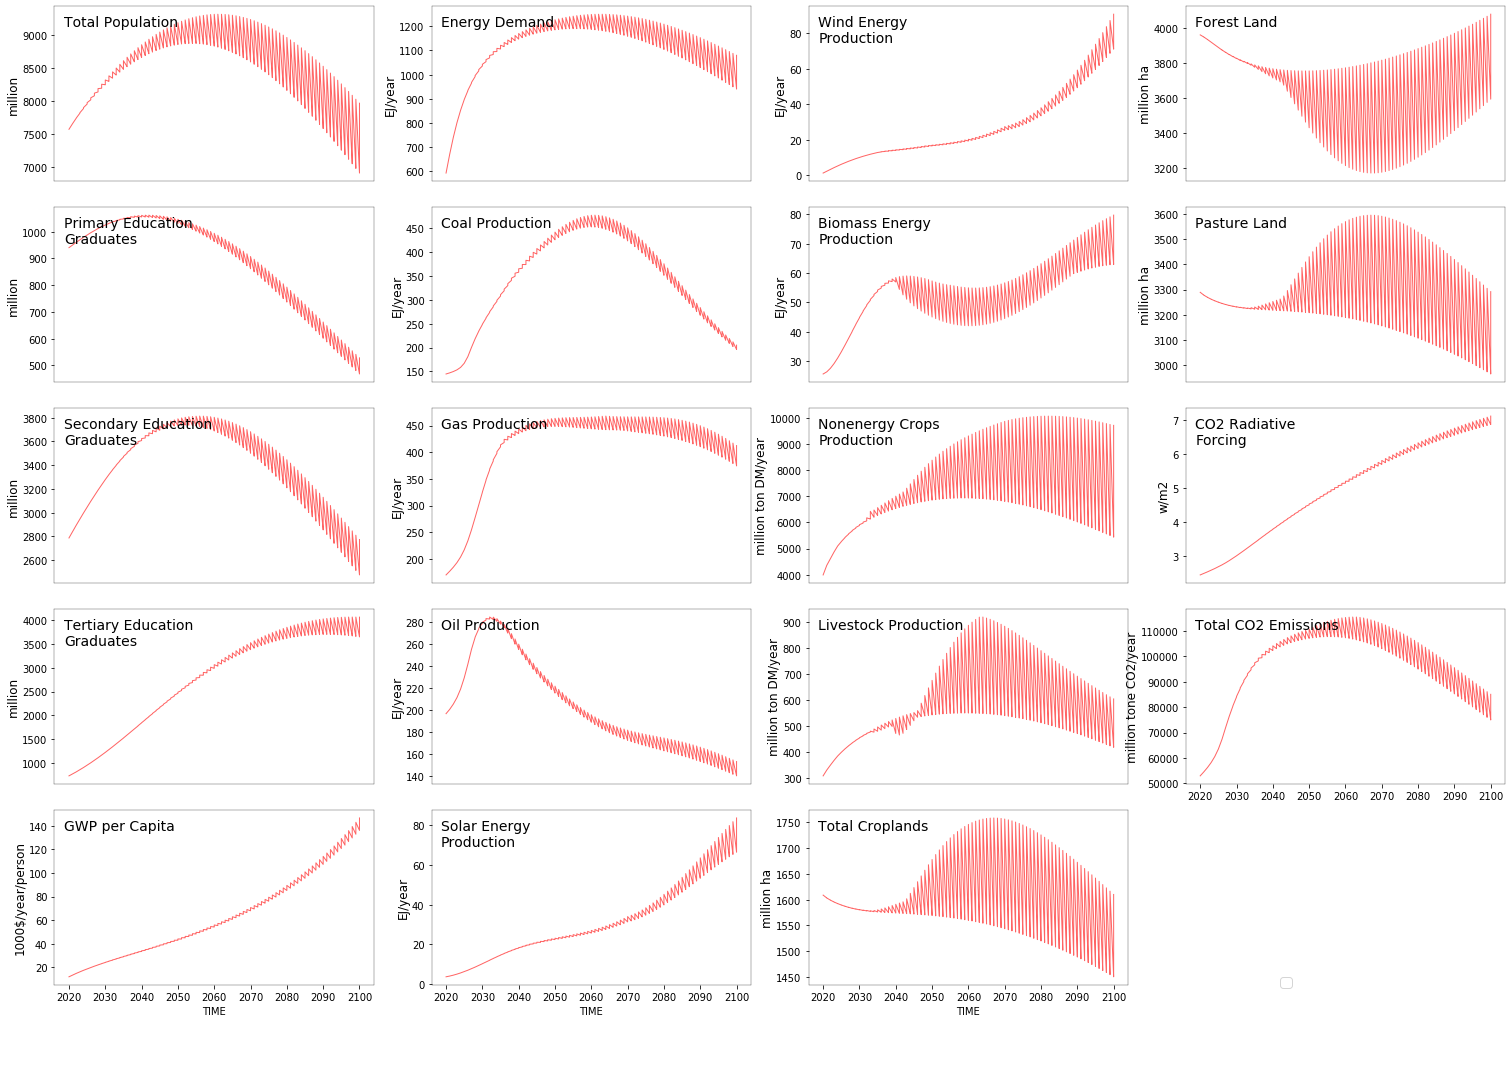

In [158]:
# Ploting Felix SSP projections across outcome variables with their historical data.

from textwrap import wrap

# Import Felix model generated projections. 
directory = 'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Data/Vensim_calibration/' 
ssps_felix = {}
for s, sc in enumerate(['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5']):
    ssps_felix[sc] = pd.read_csv(directory+"{}_FeliX.csv".format(sc))
    ssps_felix[sc] = ssps_felix[sc].set_index('Time').transpose()
    ssps_felix[sc]['Time'] = ssps_felix[sc].index
    ssps_felix[sc].rename(columns={'CO2 Radiative Forcing': 'CO2 Radiative Forcing Indicator', 'Time':'TIME'}, inplace=True)

# Customise y-axis label names to include the units
y_labels = {'Total Population Indicator':'million', 
             'Total Primary Education Graduates Indicator':'million',
             'Total Secondary Education Graduates Indicator':'million',
              'Total Tertiary Education Graduates Indicator':'million', 
              'GWP per Capita Indicator':'1000$/year/person',
             'Energy Demand Indicator': 'EJ/year',
             'Coal Production Indicator':'EJ/year', 
              'Gas Production Indicator':'EJ/year', 
              'Oil Production Indicator':'EJ/year', 
              'Solar Energy Production Indicator':'EJ/year', 
              'Wind Energy Production Indicator':'EJ/year', 
            'Biomass Energy Production Indicator':'EJ/year',
             'Nonenergy Crops Production Indicator':'million ton DM/year', 
              'Livestock Production Indicator':'million ton DM/year',  
              'Total Croplands Indicator':'million ha', 
             'Forest Land Indicator':'million ha', 
              'Pasture Land Indicator':'million ha', 
              'CO2 Radiative Forcing Indicator': 'w/m2',
             'Total CO2 Emissions Indicator': 'million tone CO2/year'}

# Customise plot titles
titles = {'Total Population Indicator':'Total Population', 
             'Total Primary Education Graduates Indicator':'Primary Education Graduates',
             'Total Secondary Education Graduates Indicator':'Secondary Education Graduates',
              'Total Tertiary Education Graduates Indicator':'Tertiary Education Graduates', 
              'GWP per Capita Indicator':'GWP per Capita',
             'Energy Demand Indicator': 'Energy Demand',
             'Coal Production Indicator':'Coal Production', 
              'Gas Production Indicator':'Gas Production', 
              'Oil Production Indicator':'Oil Production', 
              'Solar Energy Production Indicator':'Solar Energy Production', 
              'Wind Energy Production Indicator':'Wind Energy Production', 
            'Biomass Energy Production Indicator':'Biomass Energy Production',
             'Nonenergy Crops Production Indicator':'Nonenergy Crops Production', 
              'Livestock Production Indicator':'Livestock Production',  
              'Total Croplands Indicator':'Total Croplands', 
             'Forest Land Indicator':'Forest Land', 
              'Pasture Land Indicator':'Pasture Land', 
              'CO2 Radiative Forcing Indicator': 'CO2 Radiative Forcing',
             'Total CO2 Emissions Indicator': 'Total CO2 Emissions'}

 
    
#sc_colors = {'SSP1': '#27706B','SSP2':'#DFDCD4','SSP3':'#FFC3AF', 'SSP4':'#DF6589', 'SSP5':'#EBA23E', 'Historical':'grey'}
#sc_colors = {'SSP1': '#A8C653','SSP2':'#DFDCD4','SSP3':'#FCCF61', 'SSP4':'#32645C', 'SSP5':'#B65748', 'Historical':'grey'}
#sc_colors = {'SSP1': '#49b462','SSP2':'grey','SSP3':'#DA274D', 'SSP4':'#F8D586', 'SSP5':'#274C71', 'Historical':'black'}
sc_colors = {'SSP1': '#1fab89','SSP2':'#f6cd61','SSP3':'#d1478c', 'SSP4':'#26baee', 'SSP5':'#ff6464', 'Historical':'black'}

fig, axes = plt.subplots(5, 4, figsize=(26, 18), sharex='col')
fig.subplots_adjust(hspace=0.15, wspace=0.18)

i = 0
j = 0
for v, var in enumerate(list(y_labels.keys())):
    if i == 5:
        i = 0
        j += 1
    for s, sc in enumerate(['SSP5']):
        #ssps_felix[sc].plot( 'TIME', var, ax=axes[i,j], marker='',
                                                         #color=sc_colors[sc], linewidth=2)
        sns.lineplot(x='TIME', y=var,  
                     estimator=None, data=outcomes_dict[sc], ax=axes[i,j], marker='',linewidth=1, color=sc_colors[sc])
    axes[i,j].legend().set_visible(False)
    axes[i,j].set_ylabel(y_labels[var], size=12, labelpad=2)
    axes[i,j].annotate('\n'.join(wrap(titles[var], 20)), size= 14, xy=(0.03, .95), xycoords='axes fraction', ha='left', va='top')
    i += 1

axes[4,3].axis('off')

# Removing ticks for inner plots                
for i in range(4):
    for j in range(4):
        axes[i, j].tick_params(bottom=False)
axes[3, 3].tick_params(axis='x', reset=True, top=False)

# Create a single legend for all subplots
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=1, fontsize=14, 
           bbox_to_anchor=(0.69, 0.064), fancybox=True, borderaxespad=0)

#plt.savefig('{}/SSPs_Felix_plots_600dpi.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 


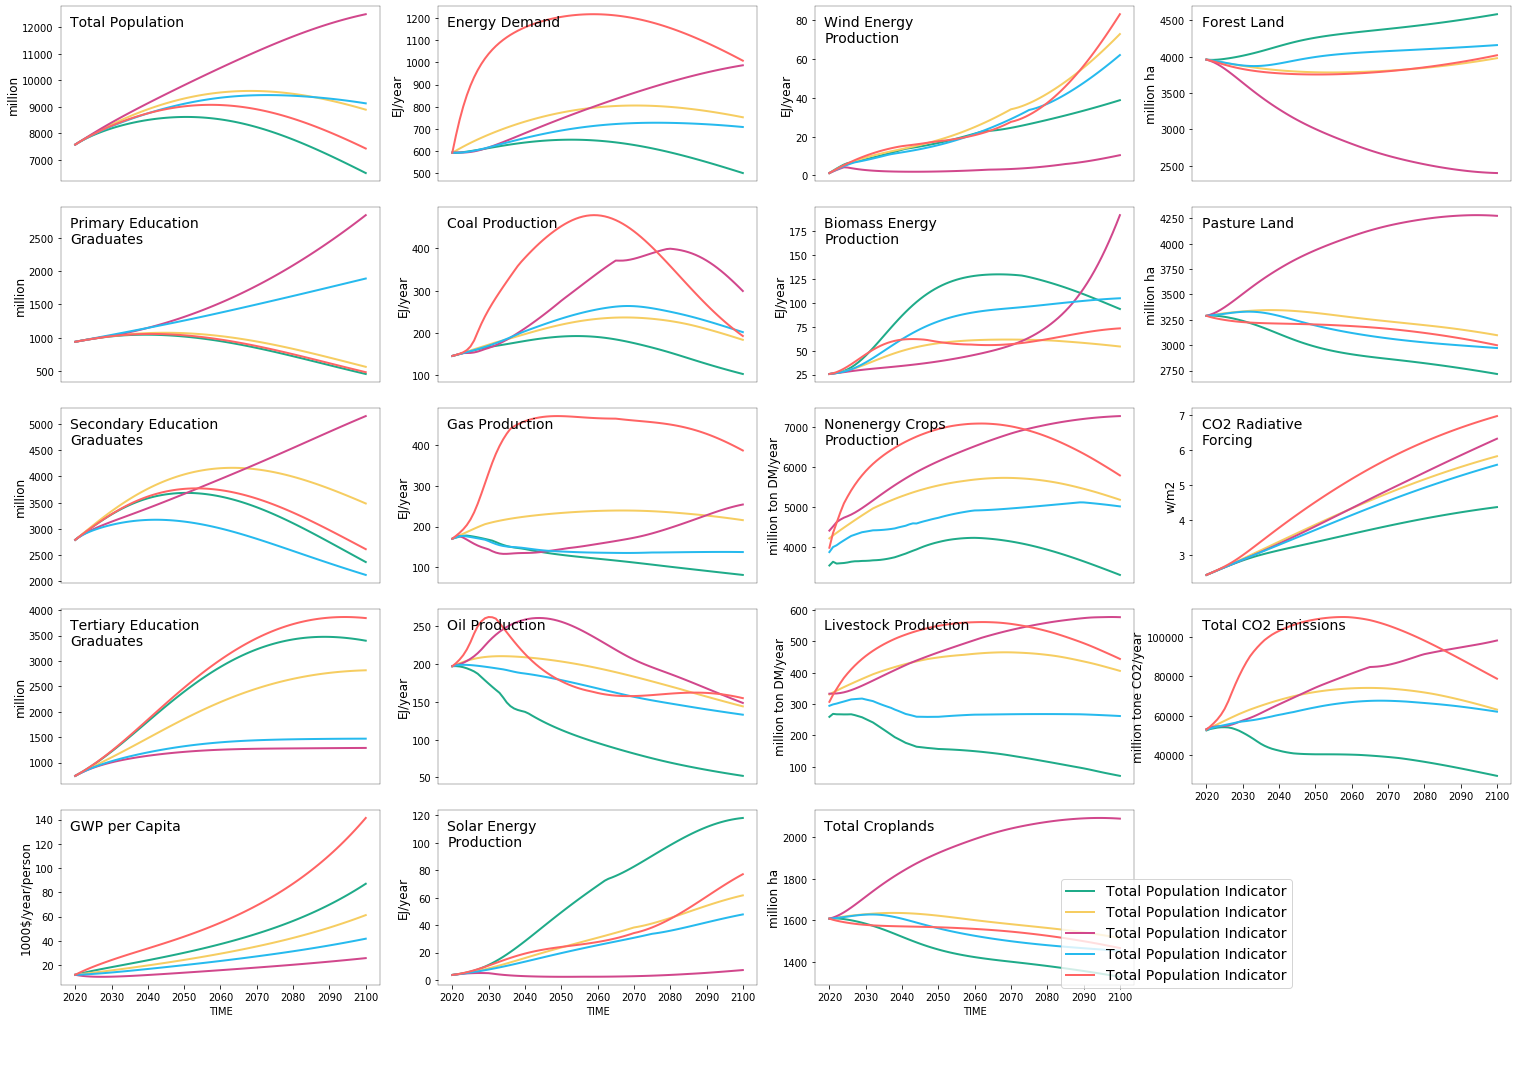

In [143]:
# Ploting Felix SSP projections across outcome variables with their historical data.

from textwrap import wrap

# Import Felix model generated projections. 

directory = 'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Data/Vensim_calibration/' 

ssps_felix = {}
for s, sc in enumerate(['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5']):
    ssps_felix[sc] = pd.read_csv(directory+"{}_FeliX.csv".format(sc))
    ssps_felix[sc] = ssps_felix[sc].set_index('Time').transpose()
    ssps_felix[sc]['Time'] = ssps_felix[sc].index
    ssps_felix[sc].rename(columns={'CO2 Radiative Forcing': 'CO2 Radiative Forcing Indicator', 'Time':'TIME'}, inplace=True)

# Customise y-axis label names to include the units
y_labels = {'Total Population Indicator':'million', 
             'Total Primary Education Graduates Indicator':'million',
             'Total Secondary Education Graduates Indicator':'million',
              'Total Tertiary Education Graduates Indicator':'million', 
              'GWP per Capita Indicator':'1000$/year/person',
             'Energy Demand Indicator': 'EJ/year',
             'Coal Production Indicator':'EJ/year', 
              'Gas Production Indicator':'EJ/year', 
              'Oil Production Indicator':'EJ/year', 
              'Solar Energy Production Indicator':'EJ/year', 
              'Wind Energy Production Indicator':'EJ/year', 
            'Biomass Energy Production Indicator':'EJ/year',
             'Nonenergy Crops Production Indicator':'million ton DM/year', 
              'Livestock Production Indicator':'million ton DM/year',  
              'Total Croplands Indicator':'million ha', 
             'Forest Land Indicator':'million ha', 
              'Pasture Land Indicator':'million ha', 
              'CO2 Radiative Forcing Indicator': 'w/m2',
             'Total CO2 Emissions Indicator': 'million tone CO2/year'}

# Customise plot titles
titles = {'Total Population Indicator':'Total Population', 
             'Total Primary Education Graduates Indicator':'Primary Education Graduates',
             'Total Secondary Education Graduates Indicator':'Secondary Education Graduates',
              'Total Tertiary Education Graduates Indicator':'Tertiary Education Graduates', 
              'GWP per Capita Indicator':'GWP per Capita',
             'Energy Demand Indicator': 'Energy Demand',
             'Coal Production Indicator':'Coal Production', 
              'Gas Production Indicator':'Gas Production', 
              'Oil Production Indicator':'Oil Production', 
              'Solar Energy Production Indicator':'Solar Energy Production', 
              'Wind Energy Production Indicator':'Wind Energy Production', 
            'Biomass Energy Production Indicator':'Biomass Energy Production',
             'Nonenergy Crops Production Indicator':'Nonenergy Crops Production', 
              'Livestock Production Indicator':'Livestock Production',  
              'Total Croplands Indicator':'Total Croplands', 
             'Forest Land Indicator':'Forest Land', 
              'Pasture Land Indicator':'Pasture Land', 
              'CO2 Radiative Forcing Indicator': 'CO2 Radiative Forcing',
             'Total CO2 Emissions Indicator': 'Total CO2 Emissions'}

 
    
#sc_colors = {'SSP1': '#27706B','SSP2':'#DFDCD4','SSP3':'#FFC3AF', 'SSP4':'#DF6589', 'SSP5':'#EBA23E', 'Historical':'grey'}
#sc_colors = {'SSP1': '#A8C653','SSP2':'#DFDCD4','SSP3':'#FCCF61', 'SSP4':'#32645C', 'SSP5':'#B65748', 'Historical':'grey'}
#sc_colors = {'SSP1': '#49b462','SSP2':'grey','SSP3':'#DA274D', 'SSP4':'#F8D586', 'SSP5':'#274C71', 'Historical':'black'}
sc_colors = {'SSP1': '#1fab89','SSP2':'#f6cd61','SSP3':'#d1478c', 'SSP4':'#26baee', 'SSP5':'#ff6464', 'Historical':'black'}

fig, axes = plt.subplots(5, 4, figsize=(26, 18), sharex='col')
fig.subplots_adjust(hspace=0.15, wspace=0.18)

i = 0
j = 0
for v, var in enumerate(list(y_labels.keys())):
    if i == 5:
        i = 0
        j += 1
    for s, sc in enumerate(['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5']):
        ssps_felix[sc].plot( 'TIME', var, ax=axes[i,j], marker='',
                                                         color=sc_colors[sc], linewidth=2)
        #sns.lineplot(x='TIME', y=var,  
                     #estimator=None, data=outcomes_dict[sc], ax=axes[i,j], marker='',linewidth=1, color=sc_colors[sc])
    axes[i,j].legend().set_visible(False)
    axes[i,j].set_ylabel(y_labels[var], size=12, labelpad=2)
    axes[i,j].annotate('\n'.join(wrap(titles[var], 20)), size= 14, xy=(0.03, .95), xycoords='axes fraction', ha='left', va='top')
    i += 1

axes[4,3].axis('off')

# Removing ticks for inner plots                
for i in range(4):
    for j in range(4):
        axes[i, j].tick_params(bottom=False)
axes[3, 3].tick_params(axis='x', reset=True, top=False)

# Create a single legend for all subplots
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=1, fontsize=14, 
           bbox_to_anchor=(0.69, 0.064), fancybox=True, borderaxespad=0)

#plt.savefig('{}/SSPs_Felix_plots_600dpi.png'.format(r'C:/Users/moallemie/GitHub/SSPs_SDGs_Assessment/Fig/'), dpi=600,  bbox_inches='tight') 


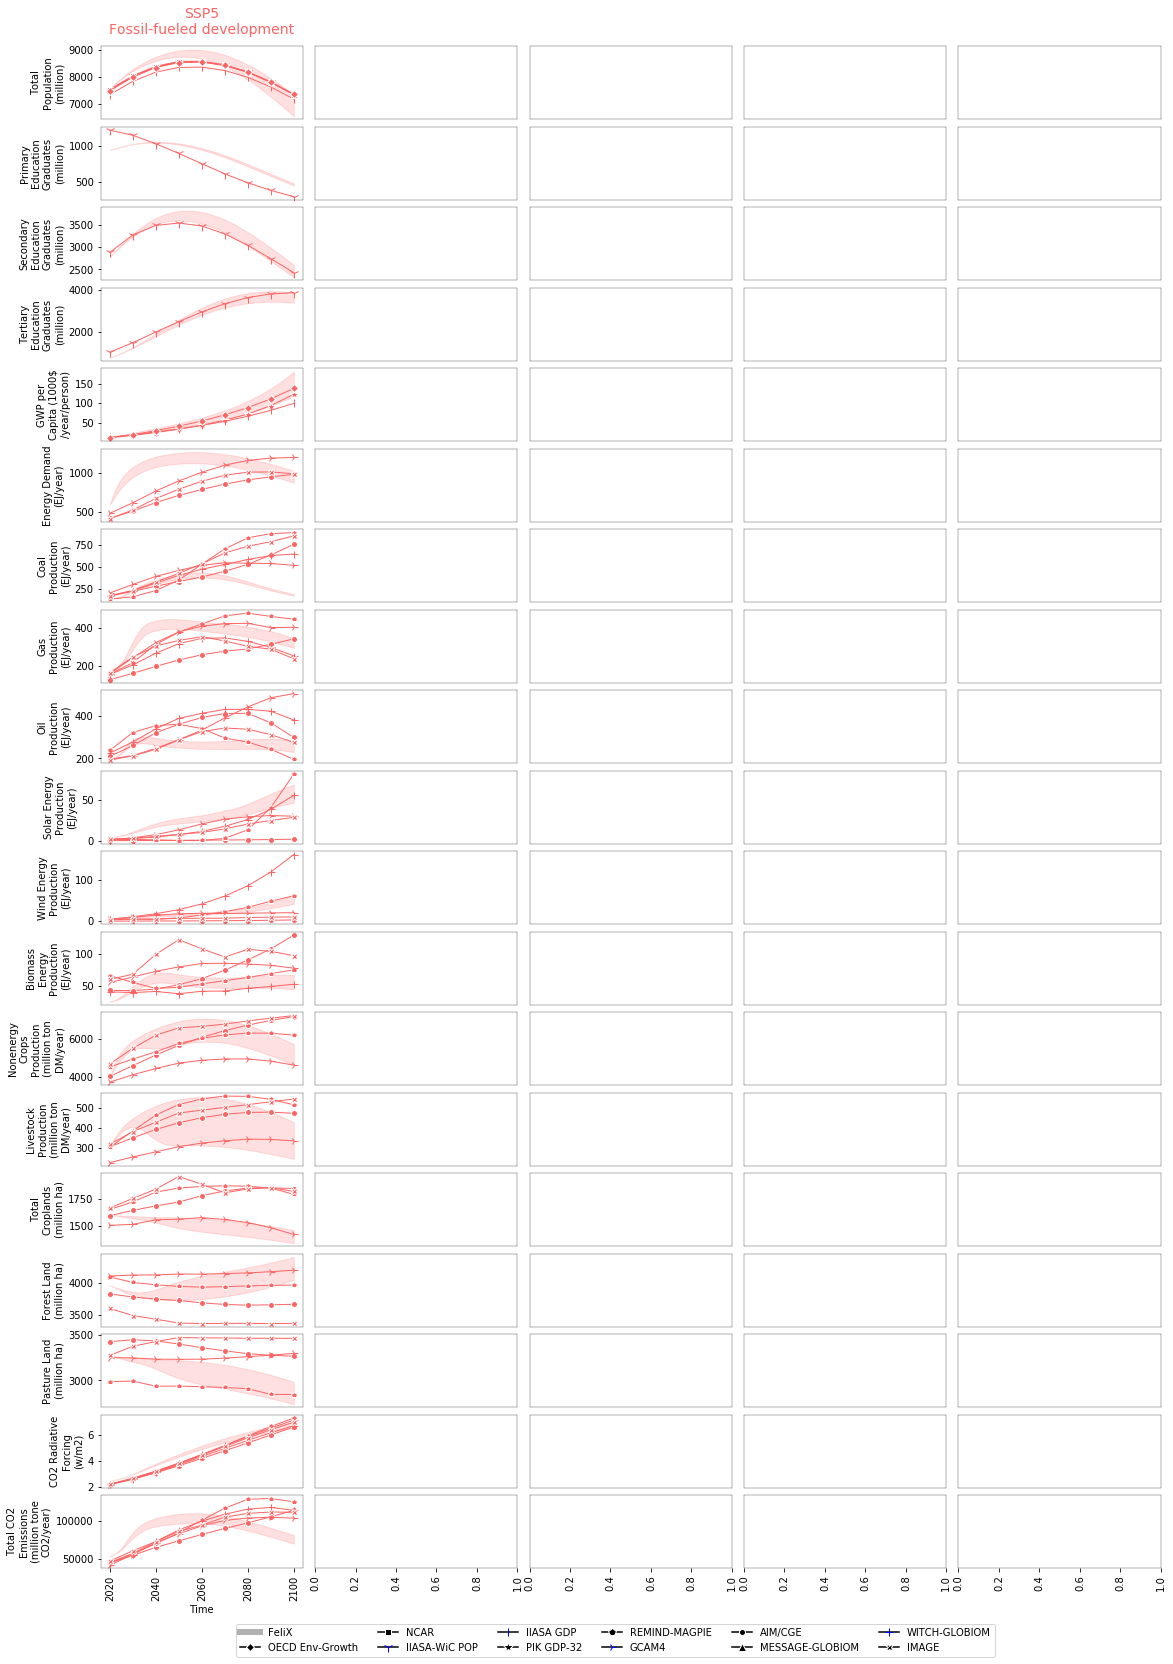

In [294]:
# Plot Felix SSP projections against other IAMs projections across all output variables
fig, ax = plt.subplots(19, 5, figsize=(19, 28), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.1, wspace=0.06)

calib_vars = ['Total Population Indicator',
 'Total Primary Education Graduates Indicator',
 'Total Secondary Education Graduates Indicator',
 'Total Tertiary Education Graduates Indicator',
 'GWP per Capita Indicator',
 'Energy Demand Indicator',
 'Coal Production Indicator',
 'Gas Production Indicator',
 'Oil Production Indicator',
 'Solar Energy Production Indicator',
 'Wind Energy Production Indicator',
 'Biomass Energy Production Indicator',
 'Nonenergy Crops Production Indicator',
 'Livestock Production Indicator',
 'Total Croplands Indicator',
 'Forest Land Indicator',
 'Pasture Land Indicator',
 'CO2 Radiative Forcing Indicator',
 'Total CO2 Emissions Indicator']


for s, sc in enumerate(['SSP5']): #
    
    # Marker dictionary: the first is marker stye, the second is marker size, the third is marker edge size, the fourth is marker edge colour
    markers = {'OECD Env-Growth':["D", 6, 1, 'white'],
     'NCAR':["s", 6, 1, 'white'],
     'IIASA-WiC POP':["1", 10, 1, sc_colors[sc]],
     'REMIND-MAGPIE':["p", 6, 1, 'white'],
     'GCAM4':["4", 8, 1, sc_colors[sc]],
     'WITCH-GLOBIOM':["+", 7, 1, sc_colors[sc]],
     'IIASA GDP':["|", 8, 1, sc_colors[sc]],
     'IMAGE':["X", 6, 1, 'white'],
     'AIM/CGE':["o", 6, 1, 'white'],
     'PIK GDP-32':["*", 9, 1, 'white'],
     'MESSAGE-GLOBIOM':["^", 6, 1, 'white']}
    
    for v, var in enumerate(calib_vars):
        
        # Renaming is for replacing var name with the model name (FeliX) for having fig legends with model name
        dict_sc_felix2 = outcomes_dict[sc].rename(columns={var:'FeliX'})
        sns.lineplot(x='TIME', y='FeliX', err_style="band", ci='sd', 
                     estimator=np.mean, data=dict_sc_felix2, ax=ax[v,s], marker='', linewidth=0, color=sc_colors[sc])
        #ax[v,s].legend().set_visible(False)
        
        ax[v,0].set_ylabel('\n'.join(wrap(unit_keys[var], 13)))
        
        for model in list(set(sc_models+pop_models+gdp_models)):
            if model in dict_var[var]['{}-Baseline'.format(sc)].columns:
                dict_var[var]['{}-Baseline'.format(sc)].plot( 'Time', model, ax=ax[v,s], marker=markers[model][0], 
                                                             markersize=markers[model][1], markeredgewidth=markers[model][2],
                                                             markerfacecolor=sc_colors[sc], markeredgecolor=markers[model][3], 
                                                             color=sc_colors[sc], linewidth=1)
                ax[v,s].legend().set_visible(False)

    # Set plots title only for the first row
    ax[0,s].set_title(ssp_names[sc], fontsize=14, color=sc_colors[sc], pad=12) 
                
# Removing ticks for inner plots                
for i in range(19):
    for j in range(5):
        if i in range(18) and j in range(5):
            ax[i, j].tick_params(bottom=False)
        if i in range(19) and j in [1,2,3,4]:
            ax[i, j].tick_params(left=False)
        if i in [18] and j in range(5):
            ax[i, j].tick_params(axis='x', rotation=90)    
            
            
# Change the color of legends and have a single unified color legend box for all subplots across SSPs 
legend_elements = [Line2D([0], [0], color='black', lw=6, alpha=.3, label='FeliX'),
                   Line2D([0], [0], marker="D", color='black', label='OECD Env-Growth', markersize=6, markerfacecolor='black', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="s", color='black', label='NCAR', markersize=6, markerfacecolor='black', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="1", color='black', label='IIASA-WiC POP', markersize=10, markerfacecolor='black', markeredgewidth=1, markeredgecolor='b'),
                   Line2D([0], [0], marker="|", color='black', label='IIASA GDP', markersize=8, markerfacecolor='black', markeredgewidth=1, markeredgecolor='b'),
                   Line2D([0], [0], marker="*", color='black', label='PIK GDP-32', markersize=10, markerfacecolor='black', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="p", color='black', label='REMIND-MAGPIE', markersize=8, markerfacecolor='black', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="4", color='black', label='GCAM4', markersize=8, markerfacecolor='black', markeredgewidth=1, markeredgecolor='b'),
                   Line2D([0], [0], marker="o", color='black', label='AIM/CGE', markersize=6, markerfacecolor='black', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="^", color='black', label='MESSAGE-GLOBIOM', markersize=8, markerfacecolor='black', markeredgewidth=1, markeredgecolor='white'),
                   Line2D([0], [0], marker="+", color='black', label='WITCH-GLOBIOM', markersize=8, markerfacecolor='black', markeredgewidth=1, markeredgecolor='b'),
                   Line2D([0], [0], marker="X", color='black', label='IMAGE', markersize=6, markerfacecolor='black', markeredgewidth=1, markeredgecolor='white')
                  ]

fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.22, .1),  bbox_transform=fig.transFigure, ncol=6)

mpl.rcParams['axes.linewidth'] = .3


#plt.savefig('{}/SSPs_calibration_plots_300dpi.png'.format(r'C:/Users/moallemie/EM_analysis/Fig/'), dpi=300,  bbox_inches='tight') 
#plt.savefig('{}/SSPs_calibration_plots_600dpi.png'.format(r'C:/Users/moallemie/EM_analysis/Fig/'), dpi=600,  bbox_inches='tight') 

plt.show()